In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/widsdatathon2025')
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'Copy of Data Dictionary.gsheet'   SAMPLE_SUBMISSION.xlsx   TRAIN      'widsdatathon notebook'
 FullDataDictionaries		   TEST			    TRAIN_NEW  'widsdatathon notebook 2'


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
%cd TRAIN_NEW
train_categorical = pd.read_csv('TRAIN_CATEGORICAL_METADATA_new.xlsx - training_combined.csv')
train_functional = pd.read_csv('TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv')
training_quantitative = pd.read_csv('TRAIN_QUANTITATIVE_METADATA_new.xlsx - training_combined.csv')
training_solutions = pd.read_csv('TRAINING_SOLUTIONS.xlsx - training_combined.csv')

/content/drive/MyDrive/widsdatathon2025/TRAIN_NEW


## **Categorical Columns Data Cleaning**

In [ ]:
train_categorical.head()

,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ
0,00aIpNTbG5uh,2019,4,1.0,0.0,3.0,21.0,45.0,NaN,NaN
1,00fV0OyyoLfw,2017,1,0.0,9.0,2.0,21.0,0.0,21.0,45.0
2,04X1eiS79T4B,2017,1,1.0,2.0,2.0,9.0,0.0,NaN,NaN
3,05ocQutkURd6,2018,1,3.0,8.0,2.0,18.0,10.0,18.0,0.0
4,06YUNBA9ZRLq,2018,1,0.0,1.0,2.0,12.0,0.0,NaN,NaN


In [ ]:
for col in train_categorical.columns:
  if train_categorical[col].isnull().sum() > 0:
    print(col)

PreInt_Demos_Fam_Child_Ethnicity
PreInt_Demos_Fam_Child_Race
MRI_Track_Scan_Location
Barratt_Barratt_P1_Edu
Barratt_Barratt_P1_Occ
Barratt_Barratt_P2_Edu
Barratt_Barratt_P2_Occ


In [ ]:
train_categorical.loc[train_categorical['PreInt_Demos_Fam_Child_Ethnicity'].isna(), ['PreInt_Demos_Fam_Child_Ethnicity']] = 3.0
train_categorical.loc[train_categorical['PreInt_Demos_Fam_Child_Race'].isna(), ['PreInt_Demos_Fam_Child_Race']] = 10.0
train_categorical.loc[train_categorical['MRI_Track_Scan_Location'].isna(), ['MRI_Track_Scan_Location']] = train_categorical['MRI_Track_Scan_Location'].mode()[0]

In [ ]:
features = ['Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu', 'Barratt_Barratt_P2_Occ']
train_categorical.loc[train_categorical['Barratt_Barratt_P2_Occ'].isna(), features]

,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ
0,21.0,45.0,NaN,NaN
2,9.0,0.0,NaN,NaN
4,12.0,0.0,NaN,NaN
9,15.0,NaN,9.0,NaN
15,18.0,25.0,NaN,NaN
...,...,...,...,...
1192,NaN,NaN,NaN,NaN
1195,15.0,25.0,NaN,NaN
1198,18.0,30.0,NaN,NaN
1203,18.0,NaN,18.0,NaN


In [ ]:
train_categorical.loc[:, 'One_Parent'] = 0
train_categorical.loc[:, 'No_Parent'] = 0
for index, row in train_categorical.iterrows():
  if pd.isna(row['Barratt_Barratt_P1_Edu']) and pd.isna(row['Barratt_Barratt_P1_Occ']) and pd.isna(row['Barratt_Barratt_P2_Edu']) and pd.isna(row['Barratt_Barratt_P2_Occ']):
    train_categorical.loc[index, 'Barratt_Barratt_P1_Edu'] = -1.0
    train_categorical.loc[index, 'Barratt_Barratt_P1_Occ'] = -1.0
    train_categorical.loc[index, 'Barratt_Barratt_P2_Edu'] = -1.0
    train_categorical.loc[index, 'Barratt_Barratt_P2_Occ'] = -1.0
    train_categorical.loc[index, 'No_Parent'] = 1
  else:
    if pd.isna(row['Barratt_Barratt_P1_Edu']) and pd.notnull(row['Barratt_Barratt_P1_Occ']):
      cur = train_categorical.loc[(train_categorical['Barratt_Barratt_P1_Occ'] == row['Barratt_Barratt_P1_Occ']), 'Barratt_Barratt_P1_Edu'].mode()[0]
      train_categorical.loc[index, 'Barratt_Barratt_P1_Edu'] = cur
    if pd.isna(row['Barratt_Barratt_P2_Edu']) and pd.notnull(row['Barratt_Barratt_P2_Occ']):
      cur = train_categorical.loc[(train_categorical['Barratt_Barratt_P2_Occ'] == row['Barratt_Barratt_P2_Occ']), 'Barratt_Barratt_P2_Edu'].mode()[0] if len(train_categorical.loc[(train_categorical['Barratt_Barratt_P2_Occ'] == row['Barratt_Barratt_P2_Occ']), 'Barratt_Barratt_P2_Edu'].mode()) > 0 else -1.0
      train_categorical.loc[index, 'Barratt_Barratt_P2_Edu'] = cur
    if pd.isna(row['Barratt_Barratt_P1_Occ']) and pd.notnull(row['Barratt_Barratt_P1_Edu']):
      cur = train_categorical.loc[(train_categorical['Barratt_Barratt_P1_Edu'] == row['Barratt_Barratt_P1_Edu']), 'Barratt_Barratt_P1_Occ'].mode()[0]
      train_categorical.loc[index, 'Barratt_Barratt_P1_Occ'] = cur
    if pd.isna(row['Barratt_Barratt_P2_Occ']) and pd.notnull(row['Barratt_Barratt_P2_Edu']):
      cur = train_categorical.loc[(train_categorical['Barratt_Barratt_P2_Edu'] == row['Barratt_Barratt_P2_Edu']), 'Barratt_Barratt_P2_Occ'].mode()[0]
      train_categorical.loc[index, 'Barratt_Barratt_P2_Occ'] = cur
    if pd.isna(row['Barratt_Barratt_P1_Edu']) and pd.isna(row['Barratt_Barratt_P1_Occ']):
      train_categorical.loc[index, 'Barratt_Barratt_P1_Edu'] = -1.0
      train_categorical.loc[index, 'Barratt_Barratt_P1_Occ'] = -1.0
      train_categorical.loc[index, 'One_Parent'] = 1
    if pd.isna(row['Barratt_Barratt_P2_Edu']) and pd.isna(row['Barratt_Barratt_P2_Occ']):
      train_categorical.loc[index, 'Barratt_Barratt_P2_Edu'] = -1.0
      train_categorical.loc[index, 'Barratt_Barratt_P2_Occ'] = -1.0
      train_categorical.loc[index, 'One_Parent'] = 1

# for col in train_categorical.columns:
#   if train_categorical[col].isnull().sum() > 0:
#     print(col)

In [ ]:
train_categorical[['Basic_Demos_Study_Site']].value_counts()

,count
Basic_Demos_Study_Site,
1,652
3,430
4,120
2,11


In [ ]:
train_categorical['Basic_Demos_Study_Site'] = train_categorical['Basic_Demos_Study_Site'].astype(object)
train_categorical.loc[train_categorical['Basic_Demos_Study_Site'] == 1, 'Basic_Demos_Study_Site'] = 'Staten Island_Study'
train_categorical.loc[train_categorical['Basic_Demos_Study_Site'] == 2, 'Basic_Demos_Study_Site'] = 'MRV'
train_categorical.loc[train_categorical['Basic_Demos_Study_Site'] == 3, 'Basic_Demos_Study_Site'] = 'Midtown'
train_categorical.loc[train_categorical['Basic_Demos_Study_Site'] == 4, 'Basic_Demos_Study_Site'] = 'Harlem'
train_categorical.loc[train_categorical['Basic_Demos_Study_Site'] == 5, 'Basic_Demos_Study_Site'] = 'SI RUMC'
train_categorical = train_categorical.join(pd.get_dummies(train_categorical['Basic_Demos_Study_Site'], dtype=float), lsuffix='_drop')
train_categorical.loc[:, ['SI RUMC']] = 0.0
train_categorical = train_categorical.drop(['Basic_Demos_Study_Site'], axis=1)
train_categorical.head()

,participant_id,Basic_Demos_Enroll_Year,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,One_Parent,No_Parent,Harlem,MRV,Midtown,Staten Island_Study,SI RUMC
0,00aIpNTbG5uh,2019,1.0,0.0,3.0,21.0,45.0,-1.0,-1.0,0,0,1.0,0.0,0.0,0.0,0.0
1,00fV0OyyoLfw,2017,0.0,9.0,2.0,21.0,0.0,21.0,45.0,0,0,0.0,0.0,0.0,1.0,0.0
2,04X1eiS79T4B,2017,1.0,2.0,2.0,9.0,0.0,-1.0,-1.0,0,0,0.0,0.0,0.0,1.0,0.0
3,05ocQutkURd6,2018,3.0,8.0,2.0,18.0,10.0,18.0,0.0,0,0,0.0,0.0,0.0,1.0,0.0
4,06YUNBA9ZRLq,2018,0.0,1.0,2.0,12.0,0.0,-1.0,-1.0,0,0,0.0,0.0,0.0,1.0,0.0


In [ ]:
train_categorical['PreInt_Demos_Fam_Child_Ethnicity'] = train_categorical['PreInt_Demos_Fam_Child_Ethnicity'].astype(object)
train_categorical.loc[train_categorical['PreInt_Demos_Fam_Child_Ethnicity'] == 0, 'PreInt_Demos_Fam_Child_Ethnicity'] = 'Not Hispanic or Latino'
train_categorical.loc[train_categorical['PreInt_Demos_Fam_Child_Ethnicity'] == 1, 'PreInt_Demos_Fam_Child_Ethnicity'] = 'Hispanic or Latino'
train_categorical.loc[train_categorical['PreInt_Demos_Fam_Child_Ethnicity'] == 2, 'PreInt_Demos_Fam_Child_Ethnicity'] = 'Decline to specify'
train_categorical.loc[train_categorical['PreInt_Demos_Fam_Child_Ethnicity'] == 3, 'PreInt_Demos_Fam_Child_Ethnicity'] = 'Unknown_Eth'
train_categorical = train_categorical.join(pd.get_dummies(train_categorical['PreInt_Demos_Fam_Child_Ethnicity'], dtype=float))
train_categorical = train_categorical.drop(['PreInt_Demos_Fam_Child_Ethnicity'], axis=1)
train_categorical.head()

,participant_id,Basic_Demos_Enroll_Year,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,One_Parent,No_Parent,Harlem,MRV,Midtown,Staten Island_Study,SI RUMC,Decline to specify,Hispanic or Latino,Not Hispanic or Latino,Unknown_Eth
0,00aIpNTbG5uh,2019,0.0,3.0,21.0,45.0,-1.0,-1.0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,00fV0OyyoLfw,2017,9.0,2.0,21.0,0.0,21.0,45.0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,04X1eiS79T4B,2017,2.0,2.0,9.0,0.0,-1.0,-1.0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,05ocQutkURd6,2018,8.0,2.0,18.0,10.0,18.0,0.0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,06YUNBA9ZRLq,2018,1.0,2.0,12.0,0.0,-1.0,-1.0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
train_categorical['PreInt_Demos_Fam_Child_Race'] = train_categorical['PreInt_Demos_Fam_Child_Race'].astype(object)
train_categorical.loc[train_categorical['PreInt_Demos_Fam_Child_Race'] == 0, 'PreInt_Demos_Fam_Child_Race'] = 'White/Caucasian'
train_categorical.loc[train_categorical['PreInt_Demos_Fam_Child_Race'] == 1, 'PreInt_Demos_Fam_Child_Race'] = 'Black/African_American'
train_categorical.loc[train_categorical['PreInt_Demos_Fam_Child_Race'] == 2, 'PreInt_Demos_Fam_Child_Race'] = 'Hispanic'
train_categorical.loc[train_categorical['PreInt_Demos_Fam_Child_Race'] == 3, 'PreInt_Demos_Fam_Child_Race'] = 'Asia'
train_categorical.loc[train_categorical['PreInt_Demos_Fam_Child_Race'] == 4, 'PreInt_Demos_Fam_Child_Race'] = 'Indian'
train_categorical.loc[train_categorical['PreInt_Demos_Fam_Child_Race'] == 5, 'PreInt_Demos_Fam_Child_Race'] = 'Native_American_Indian'
train_categorical.loc[train_categorical['PreInt_Demos_Fam_Child_Race'] == 6, 'PreInt_Demos_Fam_Child_Race'] = 'American_Indian/Alaskan_Native'
train_categorical.loc[train_categorical['PreInt_Demos_Fam_Child_Race'] == 7, 'PreInt_Demos_Fam_Child_Race'] = 'Native Hawaiian/Other_Pacific_Islander'
train_categorical.loc[train_categorical['PreInt_Demos_Fam_Child_Race'] == 8, 'PreInt_Demos_Fam_Child_Race'] = 'Two_or_more_races'
train_categorical.loc[train_categorical['PreInt_Demos_Fam_Child_Race'] == 9, 'PreInt_Demos_Fam_Child_Race'] = 'Other_race'
train_categorical.loc[train_categorical['PreInt_Demos_Fam_Child_Race'] == 10, 'PreInt_Demos_Fam_Child_Race'] = 'Unknown_Race'
train_categorical.loc[train_categorical['PreInt_Demos_Fam_Child_Race'] == 11, 'PreInt_Demos_Fam_Child_Race'] = 'Choose_not_to_specify'
train_categorical = train_categorical.join(pd.get_dummies(train_categorical['PreInt_Demos_Fam_Child_Race'], dtype=float))
train_categorical.loc[:, ['Native_American_Indian']] = 0.0
train_categorical.loc[:, ['American_Indian/Alaskan_Native']] = 0.0
train_categorical = train_categorical.drop(['PreInt_Demos_Fam_Child_Race'], axis=1)
train_categorical.head()

,participant_id,Basic_Demos_Enroll_Year,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,One_Parent,No_Parent,Harlem,...,Choose_not_to_specify,Hispanic,Indian,Native Hawaiian/Other_Pacific_Islander,Other_race,Two_or_more_races,Unknown_Race,White/Caucasian,Native_American_Indian,American_Indian/Alaskan_Native
0,00aIpNTbG5uh,2019,3.0,21.0,45.0,-1.0,-1.0,0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,00fV0OyyoLfw,2017,2.0,21.0,0.0,21.0,45.0,0,0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,04X1eiS79T4B,2017,2.0,9.0,0.0,-1.0,-1.0,0,0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,05ocQutkURd6,2018,2.0,18.0,10.0,18.0,0.0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,06YUNBA9ZRLq,2018,2.0,12.0,0.0,-1.0,-1.0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train_categorical['MRI_Track_Scan_Location'] = train_categorical['MRI_Track_Scan_Location'].astype(object)
train_categorical.loc[train_categorical['MRI_Track_Scan_Location'] == 1, 'MRI_Track_Scan_Location'] = 'Staten_Island_Scan'
train_categorical.loc[train_categorical['MRI_Track_Scan_Location'] == 2, 'MRI_Track_Scan_Location'] = 'RUBIC'
train_categorical.loc[train_categorical['MRI_Track_Scan_Location'] == 3, 'MRI_Track_Scan_Location'] = 'CBIC'
train_categorical.loc[train_categorical['MRI_Track_Scan_Location'] == 4, 'MRI_Track_Scan_Location'] = 'CUNY'
train_categorical = train_categorical.join(pd.get_dummies(train_categorical['MRI_Track_Scan_Location'], dtype=float))
train_categorical = train_categorical.drop(['MRI_Track_Scan_Location'], axis=1)
train_categorical.head()

,participant_id,Basic_Demos_Enroll_Year,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,One_Parent,No_Parent,Harlem,MRV,...,Other_race,Two_or_more_races,Unknown_Race,White/Caucasian,Native_American_Indian,American_Indian/Alaskan_Native,CBIC,CUNY,RUBIC,Staten_Island_Scan
0,00aIpNTbG5uh,2019,21.0,45.0,-1.0,-1.0,0,0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,00fV0OyyoLfw,2017,21.0,0.0,21.0,45.0,0,0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,04X1eiS79T4B,2017,9.0,0.0,-1.0,-1.0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,05ocQutkURd6,2018,18.0,10.0,18.0,0.0,0,0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,06YUNBA9ZRLq,2018,12.0,0.0,-1.0,-1.0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
train_categorical['Barratt_Barratt_P1_Edu'] = train_categorical['Barratt_Barratt_P1_Edu'].astype(object)
train_categorical.loc[train_categorical['Barratt_Barratt_P1_Edu'] == -1, 'Barratt_Barratt_P1_Edu'] = 'P1_Unknown_Edu'
train_categorical.loc[train_categorical['Barratt_Barratt_P1_Edu'] == 3, 'Barratt_Barratt_P1_Edu'] = 'P1_<7th_grade'
train_categorical.loc[train_categorical['Barratt_Barratt_P1_Edu'] == 6, 'Barratt_Barratt_P1_Edu'] = 'P1_9th_grade'
train_categorical.loc[train_categorical['Barratt_Barratt_P1_Edu'] == 9, 'Barratt_Barratt_P1_Edu'] = 'P1_10th/11th_grade'
train_categorical.loc[train_categorical['Barratt_Barratt_P1_Edu'] == 12, 'Barratt_Barratt_P1_Edu'] = 'P1_HS_Grade'
train_categorical.loc[train_categorical['Barratt_Barratt_P1_Edu'] == 15, 'Barratt_Barratt_P1_Edu'] = 'P1_Partial_College'
train_categorical.loc[train_categorical['Barratt_Barratt_P1_Edu'] == 18, 'Barratt_Barratt_P1_Edu'] = 'P1_College_Ed'
train_categorical.loc[train_categorical['Barratt_Barratt_P1_Edu'] == 21, 'Barratt_Barratt_P1_Edu'] = 'P1_Grad_Degree'
train_categorical = train_categorical.join(pd.get_dummies(train_categorical['Barratt_Barratt_P1_Edu'], dtype=float))
train_categorical = train_categorical.drop(['Barratt_Barratt_P1_Edu'], axis=1)
train_categorical.head()

,participant_id,Basic_Demos_Enroll_Year,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,One_Parent,No_Parent,Harlem,MRV,Midtown,...,RUBIC,Staten_Island_Scan,P1_10th/11th_grade,P1_9th_grade,P1_<7th_grade,P1_College_Ed,P1_Grad_Degree,P1_HS_Grade,P1_Partial_College,P1_Unknown_Edu
0,00aIpNTbG5uh,2019,45.0,-1.0,-1.0,0,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,00fV0OyyoLfw,2017,0.0,21.0,45.0,0,0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,04X1eiS79T4B,2017,0.0,-1.0,-1.0,0,0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,05ocQutkURd6,2018,10.0,18.0,0.0,0,0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,06YUNBA9ZRLq,2018,0.0,-1.0,-1.0,0,0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
train_categorical['Barratt_Barratt_P2_Edu'] = train_categorical['Barratt_Barratt_P2_Edu'].astype(object)
train_categorical.loc[train_categorical['Barratt_Barratt_P2_Edu'] == -1, 'Barratt_Barratt_P2_Edu'] = 'P2_Unknown_Edu'
train_categorical.loc[train_categorical['Barratt_Barratt_P2_Edu'] == 3, 'Barratt_Barratt_P2_Edu'] = 'P2_<7th_grade'
train_categorical.loc[train_categorical['Barratt_Barratt_P2_Edu'] == 6, 'Barratt_Barratt_P2_Edu'] = 'P2_9th_grade'
train_categorical.loc[train_categorical['Barratt_Barratt_P2_Edu'] == 9, 'Barratt_Barratt_P2_Edu'] = 'P2_10th/11th_grade'
train_categorical.loc[train_categorical['Barratt_Barratt_P2_Edu'] == 12, 'Barratt_Barratt_P2_Edu'] = 'P2_HS_Grade'
train_categorical.loc[train_categorical['Barratt_Barratt_P2_Edu'] == 15, 'Barratt_Barratt_P2_Edu'] = 'P2_Partial_College'
train_categorical.loc[train_categorical['Barratt_Barratt_P2_Edu'] == 18, 'Barratt_Barratt_P2_Edu'] = 'P2_College_Ed'
train_categorical.loc[train_categorical['Barratt_Barratt_P2_Edu'] == 21, 'Barratt_Barratt_P2_Edu'] = 'P2_Grad_Degree'
train_categorical = train_categorical.join(pd.get_dummies(train_categorical['Barratt_Barratt_P2_Edu'], dtype=float))
train_categorical = train_categorical.drop(['Barratt_Barratt_P2_Edu'], axis=1)
train_categorical.head()

,participant_id,Basic_Demos_Enroll_Year,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Occ,One_Parent,No_Parent,Harlem,MRV,Midtown,Staten Island_Study,...,P1_Partial_College,P1_Unknown_Edu,P2_10th/11th_grade,P2_9th_grade,P2_<7th_grade,P2_College_Ed,P2_Grad_Degree,P2_HS_Grade,P2_Partial_College,P2_Unknown_Edu
0,00aIpNTbG5uh,2019,45.0,-1.0,0,0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,00fV0OyyoLfw,2017,0.0,45.0,0,0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,04X1eiS79T4B,2017,0.0,-1.0,0,0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,05ocQutkURd6,2018,10.0,0.0,0,0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,06YUNBA9ZRLq,2018,0.0,-1.0,0,0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
train_categorical[['Barratt_Barratt_P2_Occ']].value_counts()

,count
Barratt_Barratt_P2_Occ,
45.0,239
35.0,207
-1.0,184
30.0,154
40.0,123
15.0,98
0.0,65
20.0,41
10.0,39


In [ ]:
train_categorical['Barratt_Barratt_P1_Occ'] = train_categorical['Barratt_Barratt_P1_Occ'].astype(object)
train_categorical.loc[train_categorical['Barratt_Barratt_P1_Occ'] == -1, 'Barratt_Barratt_P1_Occ'] = 'P1_Unknown_Occ'
train_categorical.loc[train_categorical['Barratt_Barratt_P1_Occ'] == 0, 'Barratt_Barratt_P1_Occ'] = 'P1_Unemployed'
train_categorical.loc[train_categorical['Barratt_Barratt_P1_Occ'] == 5, 'Barratt_Barratt_P1_Occ'] = 'P1_Unskilled'
train_categorical.loc[train_categorical['Barratt_Barratt_P1_Occ'] == 10, 'Barratt_Barratt_P1_Occ'] = 'P1_Semi-skilled'
train_categorical.loc[train_categorical['Barratt_Barratt_P1_Occ'] == 15, 'Barratt_Barratt_P1_Occ'] = 'P1_Skilled'
train_categorical.loc[train_categorical['Barratt_Barratt_P1_Occ'] == 20, 'Barratt_Barratt_P1_Occ'] = 'P1_Clerical'
train_categorical.loc[train_categorical['Barratt_Barratt_P1_Occ'] == 25, 'Barratt_Barratt_P1_Occ'] = 'P1_Technical'
train_categorical.loc[train_categorical['Barratt_Barratt_P1_Occ'] == 30, 'Barratt_Barratt_P1_Occ'] = 'P1_Semi-professional'
train_categorical.loc[train_categorical['Barratt_Barratt_P1_Occ'] == 35, 'Barratt_Barratt_P1_Occ'] = 'P1_Professional'
train_categorical.loc[train_categorical['Barratt_Barratt_P1_Occ'] == 40, 'Barratt_Barratt_P1_Occ'] = 'P1_Executive'
train_categorical.loc[train_categorical['Barratt_Barratt_P1_Occ'] == 45, 'Barratt_Barratt_P1_Occ'] = 'P1_Elite'
train_categorical = train_categorical.join(pd.get_dummies(train_categorical['Barratt_Barratt_P1_Occ'], dtype=float))
train_categorical = train_categorical.drop(['Barratt_Barratt_P1_Occ'], axis=1)
train_categorical.head()

,participant_id,Basic_Demos_Enroll_Year,Barratt_Barratt_P2_Occ,One_Parent,No_Parent,Harlem,MRV,Midtown,Staten Island_Study,SI RUMC,...,P1_Elite,P1_Executive,P1_Professional,P1_Semi-professional,P1_Semi-skilled,P1_Skilled,P1_Technical,P1_Unemployed,P1_Unknown_Occ,P1_Unskilled
0,00aIpNTbG5uh,2019,-1.0,0,0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00fV0OyyoLfw,2017,45.0,0,0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,04X1eiS79T4B,2017,-1.0,0,0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,05ocQutkURd6,2018,0.0,0,0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,06YUNBA9ZRLq,2018,-1.0,0,0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
train_categorical['Barratt_Barratt_P2_Occ'] = train_categorical['Barratt_Barratt_P2_Occ'].astype(object)
train_categorical.loc[train_categorical['Barratt_Barratt_P2_Occ'] == -1, 'Barratt_Barratt_P2_Occ'] = 'P2_Unknown_Occ'
train_categorical.loc[train_categorical['Barratt_Barratt_P2_Occ'] == 0, 'Barratt_Barratt_P2_Occ'] = 'P2_Unemployed'
train_categorical.loc[train_categorical['Barratt_Barratt_P2_Occ'] == 5, 'Barratt_Barratt_P2_Occ'] = 'P2_Unskilled'
train_categorical.loc[train_categorical['Barratt_Barratt_P2_Occ'] == 10, 'Barratt_Barratt_P2_Occ'] = 'P2_Semi-skilled'
train_categorical.loc[train_categorical['Barratt_Barratt_P2_Occ'] == 15, 'Barratt_Barratt_P2_Occ'] = 'P2_Skilled'
train_categorical.loc[train_categorical['Barratt_Barratt_P2_Occ'] == 20, 'Barratt_Barratt_P2_Occ'] = 'P2_Clerical'
train_categorical.loc[train_categorical['Barratt_Barratt_P2_Occ'] == 25, 'Barratt_Barratt_P2_Occ'] = 'P2_Technical'
train_categorical.loc[train_categorical['Barratt_Barratt_P2_Occ'] == 30, 'Barratt_Barratt_P2_Occ'] = 'P2_Semi-professional'
train_categorical.loc[train_categorical['Barratt_Barratt_P2_Occ'] == 35, 'Barratt_Barratt_P2_Occ'] = 'P2_Professional'
train_categorical.loc[train_categorical['Barratt_Barratt_P2_Occ'] == 40, 'Barratt_Barratt_P2_Occ'] = 'P2_Executive'
train_categorical.loc[train_categorical['Barratt_Barratt_P2_Occ'] == 45, 'Barratt_Barratt_P2_Occ'] = 'P2_Elite'
train_categorical = train_categorical.join(pd.get_dummies(train_categorical['Barratt_Barratt_P2_Occ'], dtype=float))
train_categorical = train_categorical.drop(['Barratt_Barratt_P2_Occ'], axis=1)
train_categorical.head()

,participant_id,Basic_Demos_Enroll_Year,One_Parent,No_Parent,Harlem,MRV,Midtown,Staten Island_Study,SI RUMC,Decline to specify,...,P2_Elite,P2_Executive,P2_Professional,P2_Semi-professional,P2_Semi-skilled,P2_Skilled,P2_Technical,P2_Unemployed,P2_Unknown_Occ,P2_Unskilled
0,00aIpNTbG5uh,2019,0,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,00fV0OyyoLfw,2017,0,0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,04X1eiS79T4B,2017,0,0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,05ocQutkURd6,2018,0,0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,06YUNBA9ZRLq,2018,0,0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## **Quantitative Column Data Cleaning**

In [ ]:
training_quantitative

,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,00aIpNTbG5uh,100.00,13.0,3.0,15.0,44.0,14.0,20.0,27.0,3.0,17.0,4.0,11.0,5.0,8.0,6.0,2.0,9.0,14.274127
1,00fV0OyyoLfw,92.27,14.0,3.0,12.0,35.0,25.0,28.0,30.0,5.0,20.0,4.0,13.0,5.0,8.0,7.0,3.0,8.0,NaN
2,04X1eiS79T4B,86.67,14.0,3.0,21.0,37.0,18.0,26.0,28.0,3.0,24.0,7.0,10.0,10.0,7.0,14.0,7.0,7.0,13.463381
3,05ocQutkURd6,93.34,14.0,3.0,11.0,42.0,15.0,20.0,28.0,0.0,5.0,0.0,3.0,0.0,3.0,2.0,2.0,6.0,9.572553
4,06YUNBA9ZRLq,0.00,14.0,8.0,12.0,35.0,22.0,12.0,24.0,6.0,23.0,7.0,15.0,8.0,9.0,8.0,1.0,4.0,6.654574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1208,zwjJWCRzKhDz,100.00,14.0,3.0,14.0,36.0,18.0,13.0,22.0,5.0,20.0,5.0,13.0,5.0,8.0,7.0,2.0,8.0,11.272986
1209,zwXD5v17Rx01,46.67,14.0,3.0,18.0,42.0,21.0,15.0,25.0,2.0,5.0,0.0,5.0,0.0,3.0,0.0,0.0,7.0,7.364020
1210,zWzLCi3NTBTd,-40.00,14.0,3.0,19.0,34.0,20.0,20.0,25.0,2.0,14.0,3.0,9.0,3.0,7.0,5.0,2.0,9.0,9.962126
1211,Zy9GTHDxUbXU,100.00,14.0,3.0,9.0,45.0,23.0,11.0,30.0,1.0,10.0,0.0,8.0,5.0,7.0,2.0,2.0,7.0,NaN


In [ ]:
for col in training_quantitative.columns:
  if training_quantitative[col].isnull().sum() > 0:
    print(col)

EHQ_EHQ_Total
ColorVision_CV_Score
APQ_P_APQ_P_CP
APQ_P_APQ_P_ID
APQ_P_APQ_P_INV
APQ_P_APQ_P_OPD
APQ_P_APQ_P_PM
APQ_P_APQ_P_PP
SDQ_SDQ_Conduct_Problems
SDQ_SDQ_Difficulties_Total
SDQ_SDQ_Emotional_Problems
SDQ_SDQ_Externalizing
SDQ_SDQ_Generating_Impact
SDQ_SDQ_Hyperactivity
SDQ_SDQ_Internalizing
SDQ_SDQ_Peer_Problems
SDQ_SDQ_Prosocial
MRI_Track_Age_at_Scan


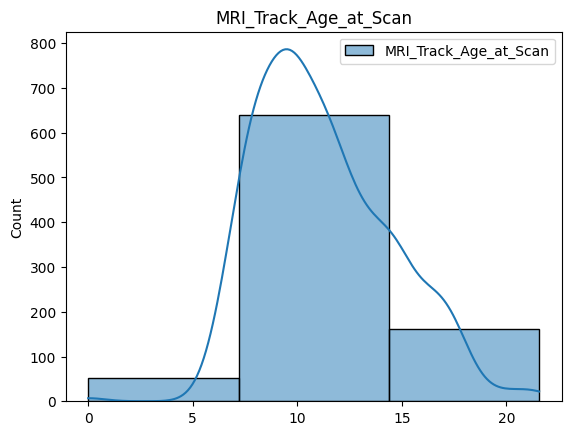

In [ ]:
sns.histplot(training_quantitative[['MRI_Track_Age_at_Scan']], kde=True, bins=3, alpha=0.5)
plt.title("MRI_Track_Age_at_Scan")
plt.show()

In [ ]:
training_quantitative.loc[training_quantitative['MRI_Track_Age_at_Scan'].isna(), ['MRI_Track_Age_at_Scan']] = training_quantitative['MRI_Track_Age_at_Scan'].mean()

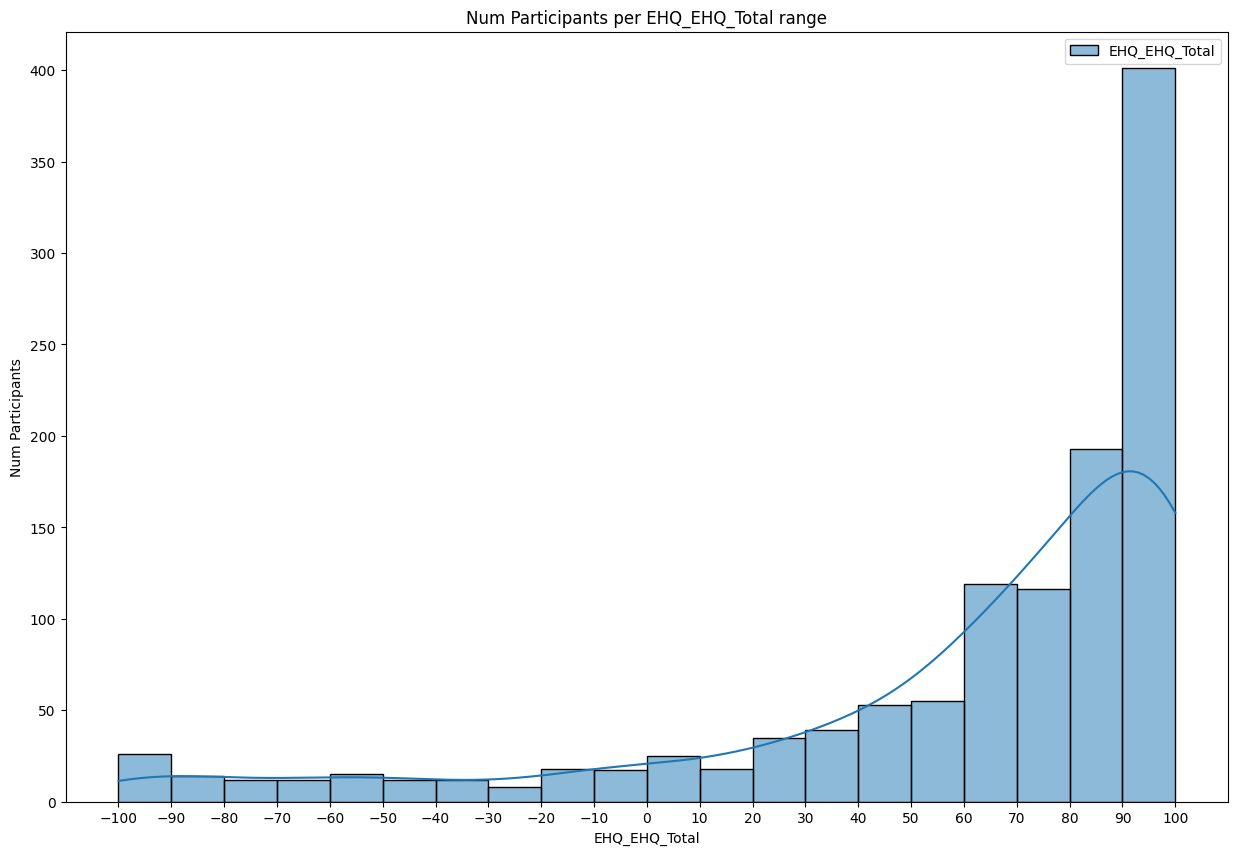

In [ ]:
# training_quantitative['EHQ_EHQ_Total'].median()
plt.figure(figsize=(15, 10))
ax = sns.histplot(training_quantitative[['EHQ_EHQ_Total']], kde=True, bins=20, alpha=0.5)
ax.set_xticks([-100, -90, -80, -70, -60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.title("Num Participants per EHQ_EHQ_Total range")
plt.ylabel("Num Participants")
plt.xlabel("EHQ_EHQ_Total")
plt.show()

In [ ]:
training_quantitative.loc[training_quantitative['EHQ_EHQ_Total'].isnull(), 'EHQ_EHQ_Total'] = training_quantitative['EHQ_EHQ_Total'].describe().iloc[5]

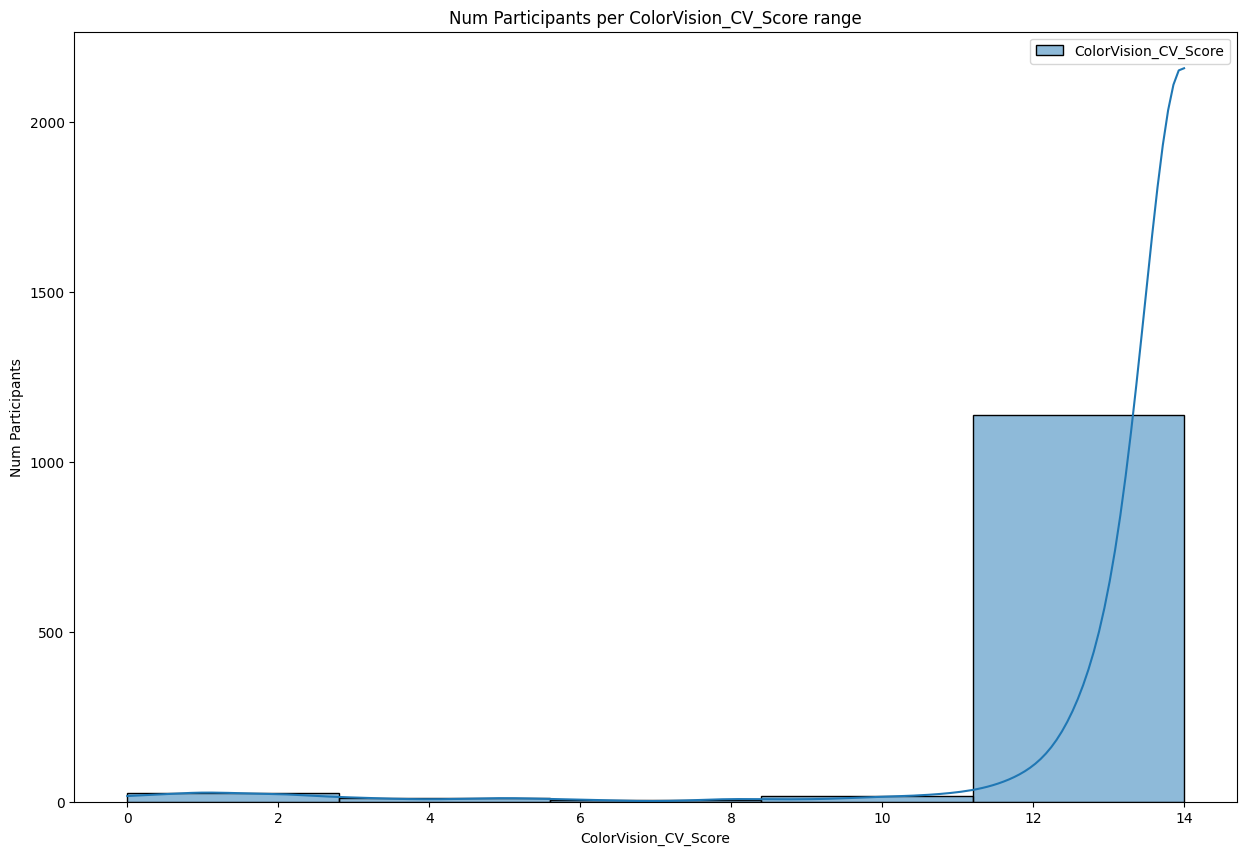

In [ ]:
plt.figure(figsize=(15, 10))
sns.histplot(training_quantitative[['ColorVision_CV_Score']], kde=True, bins=5, alpha=0.5)
plt.title("Num Participants per ColorVision_CV_Score range")
plt.ylabel("Num Participants")
plt.xlabel("ColorVision_CV_Score")
plt.show()

In [ ]:
training_quantitative.loc[training_quantitative['ColorVision_CV_Score'].isnull(), 'ColorVision_CV_Score'] = training_quantitative['ColorVision_CV_Score'].median()

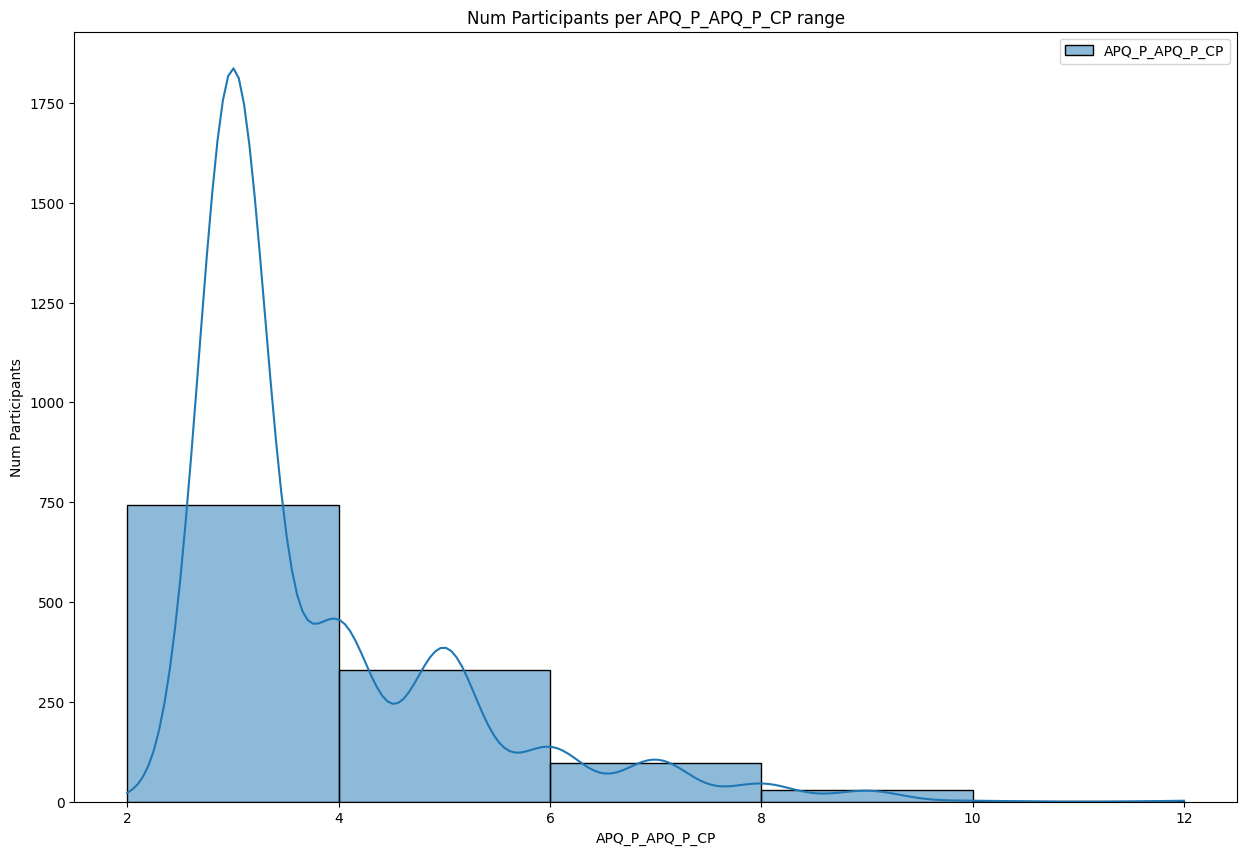

In [ ]:
plt.figure(figsize=(15, 10))
sns.histplot(training_quantitative[['APQ_P_APQ_P_CP']], kde=True, bins=5, alpha=0.5)
plt.title("Num Participants per APQ_P_APQ_P_CP range")
plt.ylabel("Num Participants")
plt.xlabel("APQ_P_APQ_P_CP")
plt.show()

In [ ]:
training_quantitative.loc[training_quantitative['APQ_P_APQ_P_CP'].isnull(), 'APQ_P_APQ_P_CP'] = training_quantitative['APQ_P_APQ_P_CP'].median()

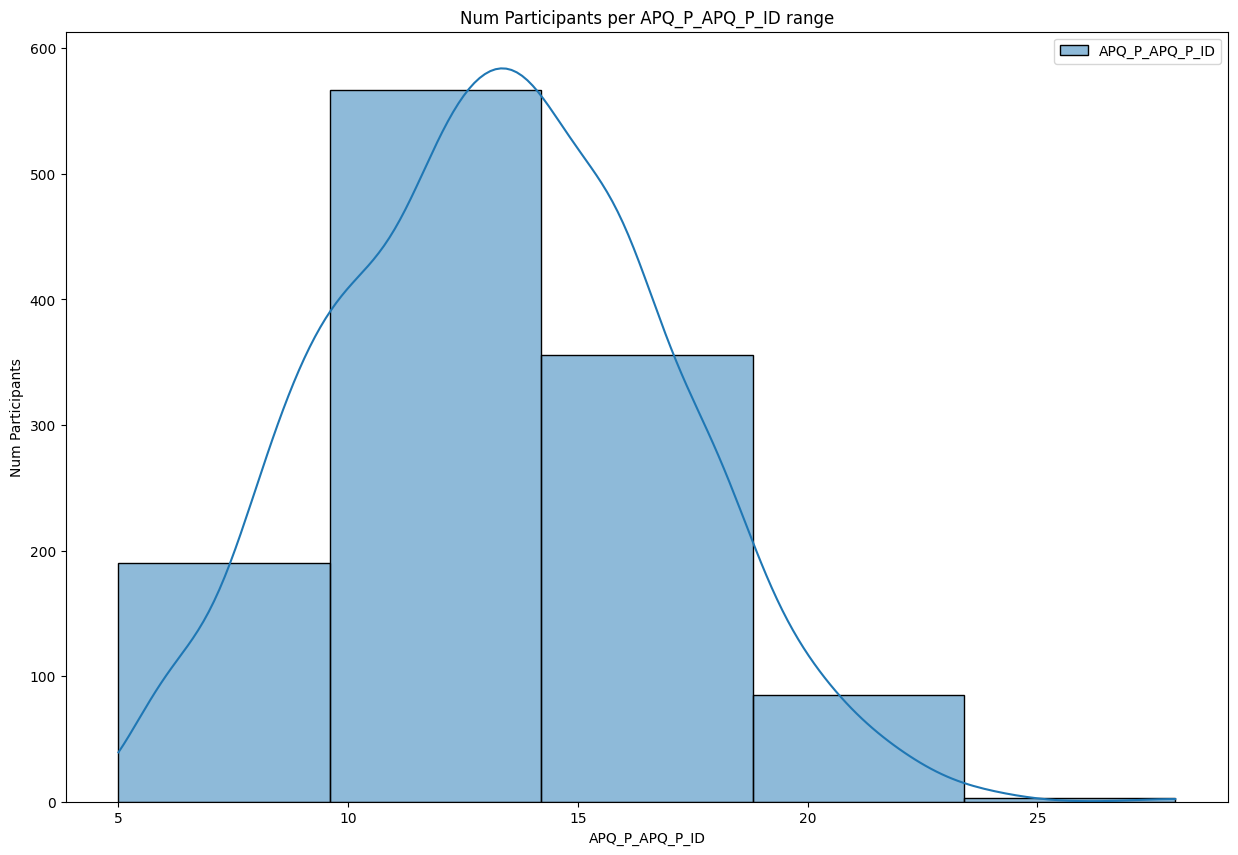

In [ ]:
plt.figure(figsize=(15, 10))
sns.histplot(training_quantitative[['APQ_P_APQ_P_ID']], kde=True, bins=5, alpha=0.5)
plt.title("Num Participants per APQ_P_APQ_P_ID range")
plt.ylabel("Num Participants")
plt.xlabel("APQ_P_APQ_P_ID")
plt.show()

In [ ]:
training_quantitative.loc[training_quantitative['APQ_P_APQ_P_ID'].isnull(), 'APQ_P_APQ_P_ID'] = training_quantitative['APQ_P_APQ_P_ID'].median()

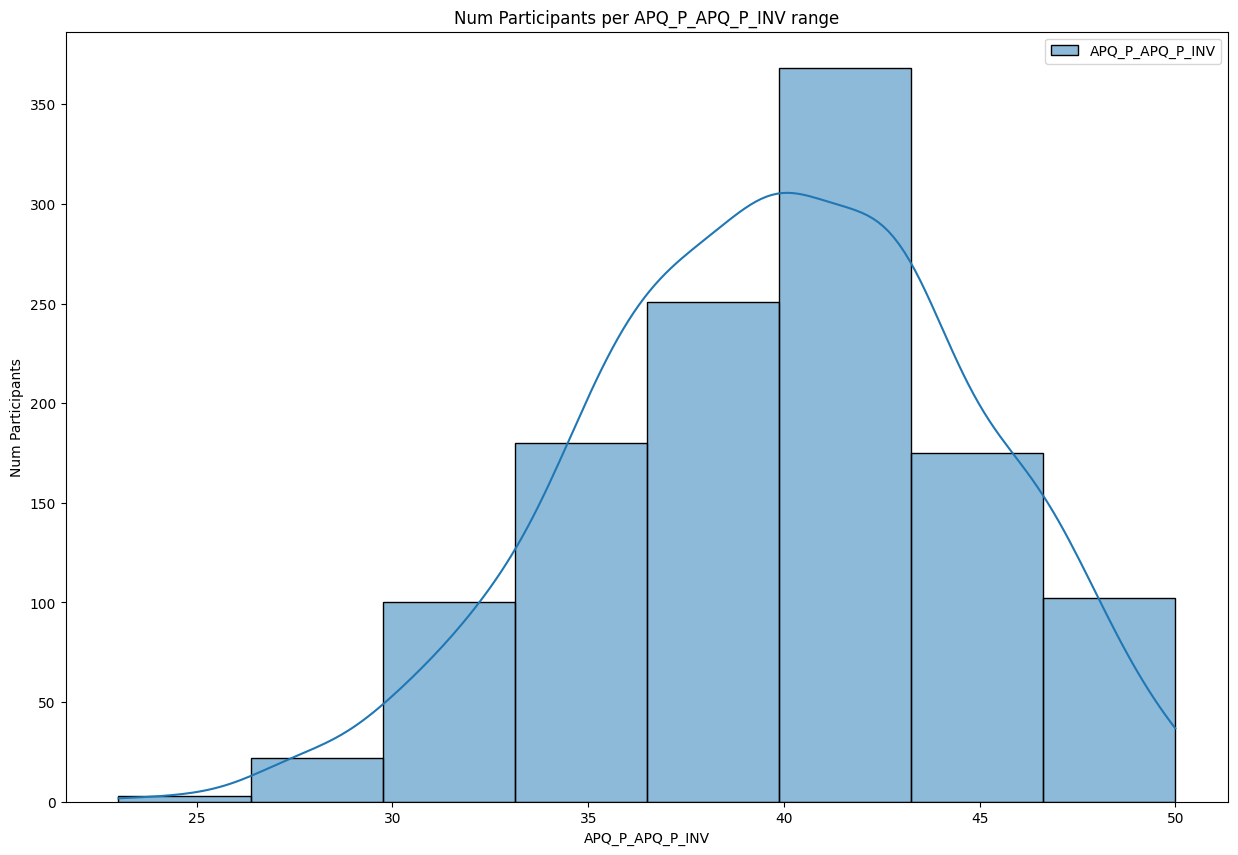

In [ ]:
plt.figure(figsize=(15, 10))
sns.histplot(training_quantitative[['APQ_P_APQ_P_INV']], kde=True, bins=8, alpha=0.5)
plt.title("Num Participants per APQ_P_APQ_P_INV range")
plt.ylabel("Num Participants")
plt.xlabel("APQ_P_APQ_P_INV")
plt.show()

In [ ]:
training_quantitative.loc[training_quantitative['APQ_P_APQ_P_INV'].isnull(), 'APQ_P_APQ_P_INV'] = training_quantitative['APQ_P_APQ_P_INV'].median()

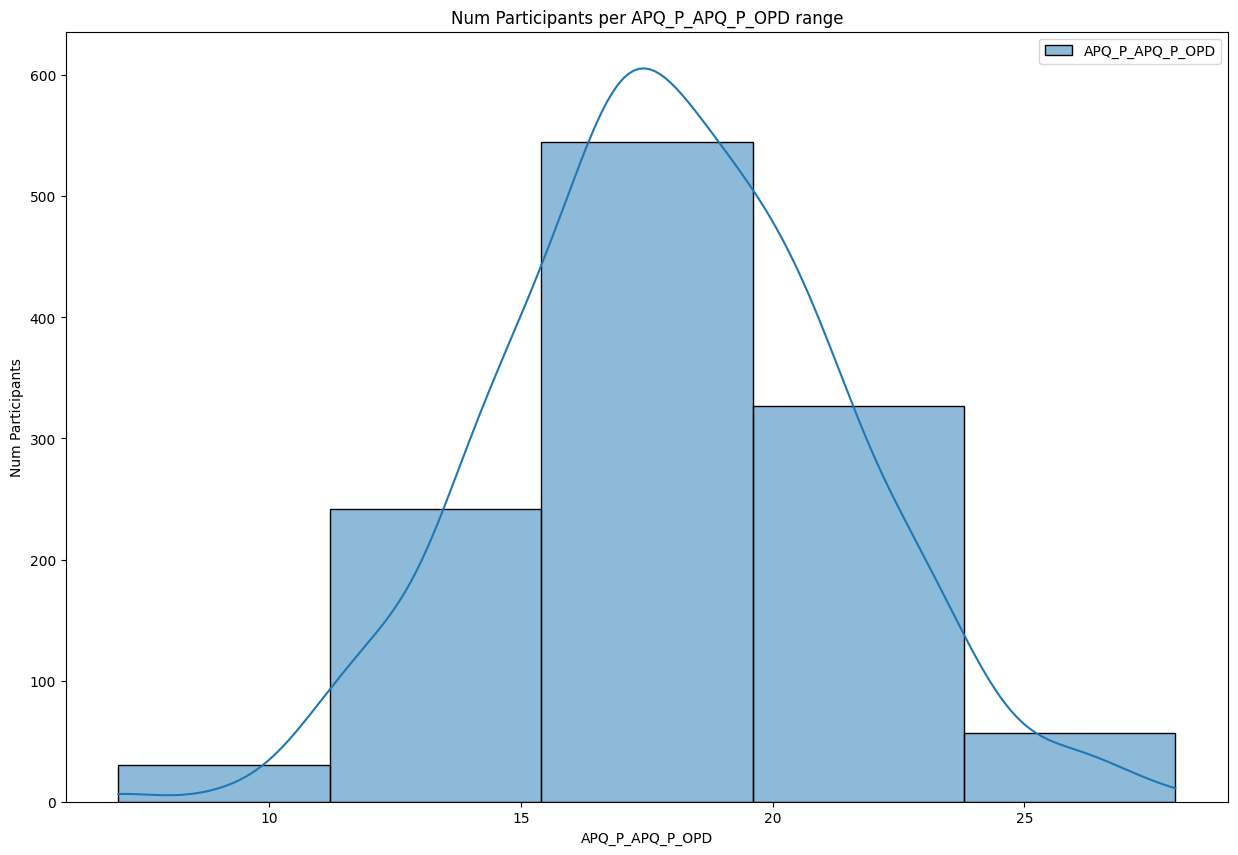

In [ ]:
plt.figure(figsize=(15, 10))
sns.histplot(training_quantitative[['APQ_P_APQ_P_OPD']], kde=True, bins=5, alpha=0.5)
plt.title("Num Participants per APQ_P_APQ_P_OPD range")
plt.ylabel("Num Participants")
plt.xlabel("APQ_P_APQ_P_OPD")
plt.show()

In [ ]:
training_quantitative.loc[training_quantitative['APQ_P_APQ_P_OPD'].isnull(), 'APQ_P_APQ_P_OPD'] = training_quantitative['APQ_P_APQ_P_OPD'].median()

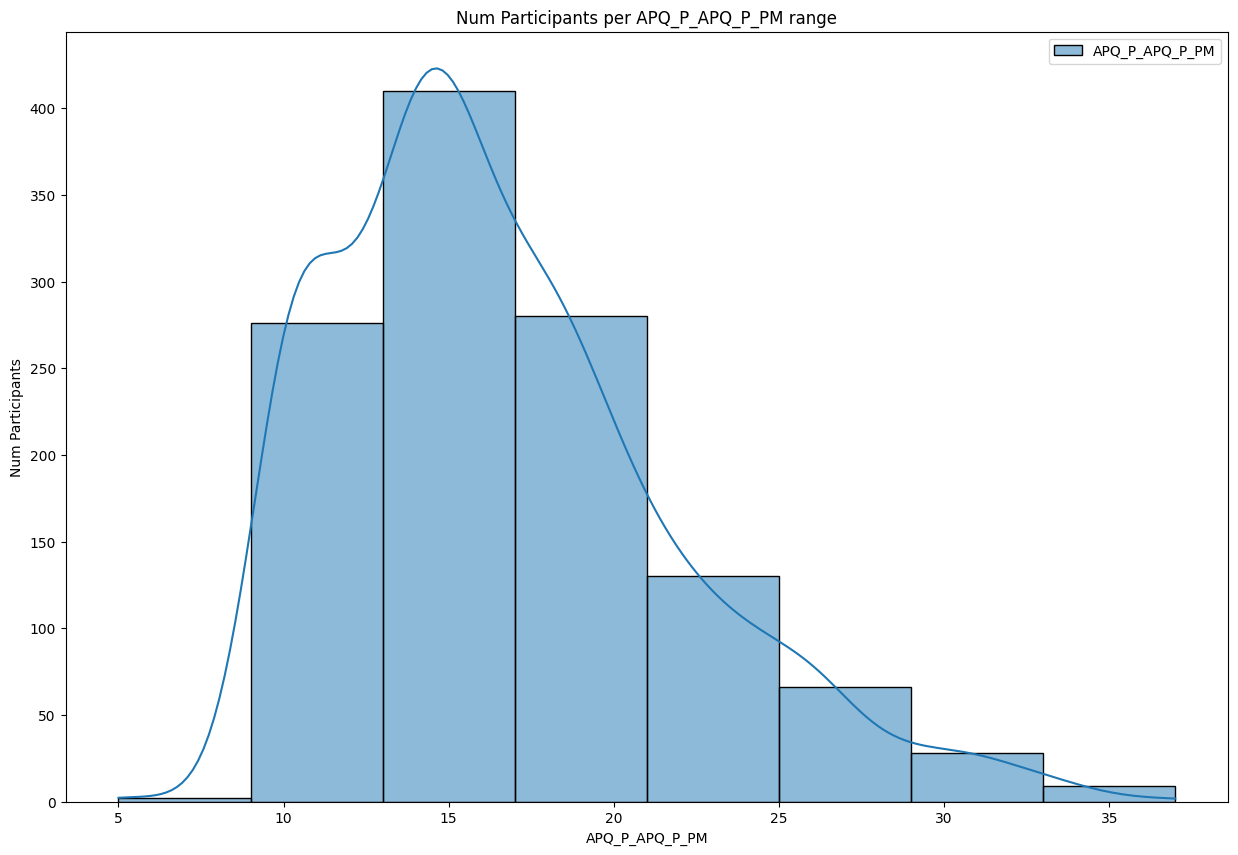

In [ ]:
plt.figure(figsize=(15, 10))
sns.histplot(training_quantitative[['APQ_P_APQ_P_PM']], kde=True, bins=8, alpha=0.5)
plt.title("Num Participants per APQ_P_APQ_P_PM range")
plt.ylabel("Num Participants")
plt.xlabel("APQ_P_APQ_P_PM")
plt.show()

In [ ]:
training_quantitative.loc[training_quantitative['APQ_P_APQ_P_PM'].isnull(), 'APQ_P_APQ_P_PM'] = training_quantitative['APQ_P_APQ_P_PM'].median()

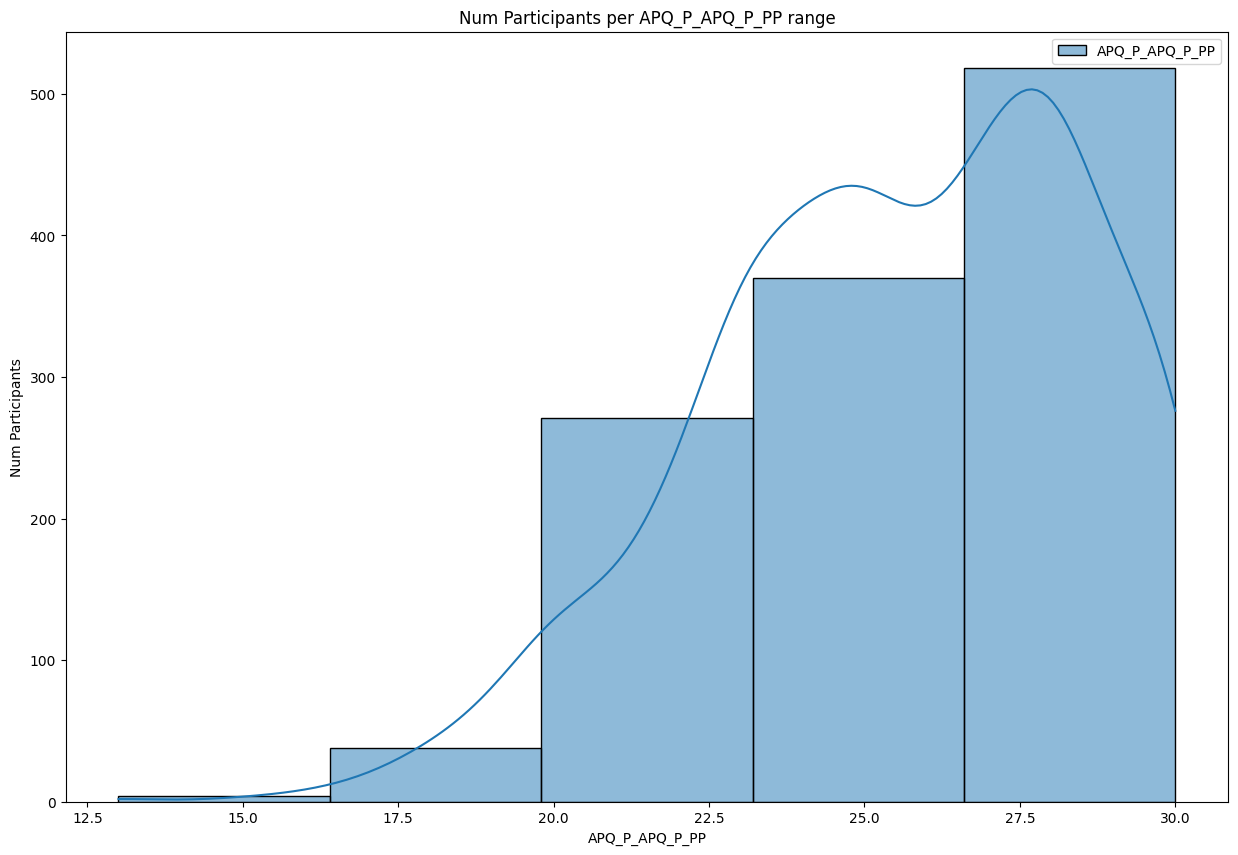

In [ ]:
plt.figure(figsize=(15, 10))
sns.histplot(training_quantitative[['APQ_P_APQ_P_PP']], kde=True, bins=5, alpha=0.5)
plt.title("Num Participants per APQ_P_APQ_P_PP range")
plt.ylabel("Num Participants")
plt.xlabel("APQ_P_APQ_P_PP")
plt.show()

In [ ]:
training_quantitative.loc[training_quantitative['APQ_P_APQ_P_PP'].isnull(), 'APQ_P_APQ_P_PP'] = training_quantitative['APQ_P_APQ_P_PP'].median()

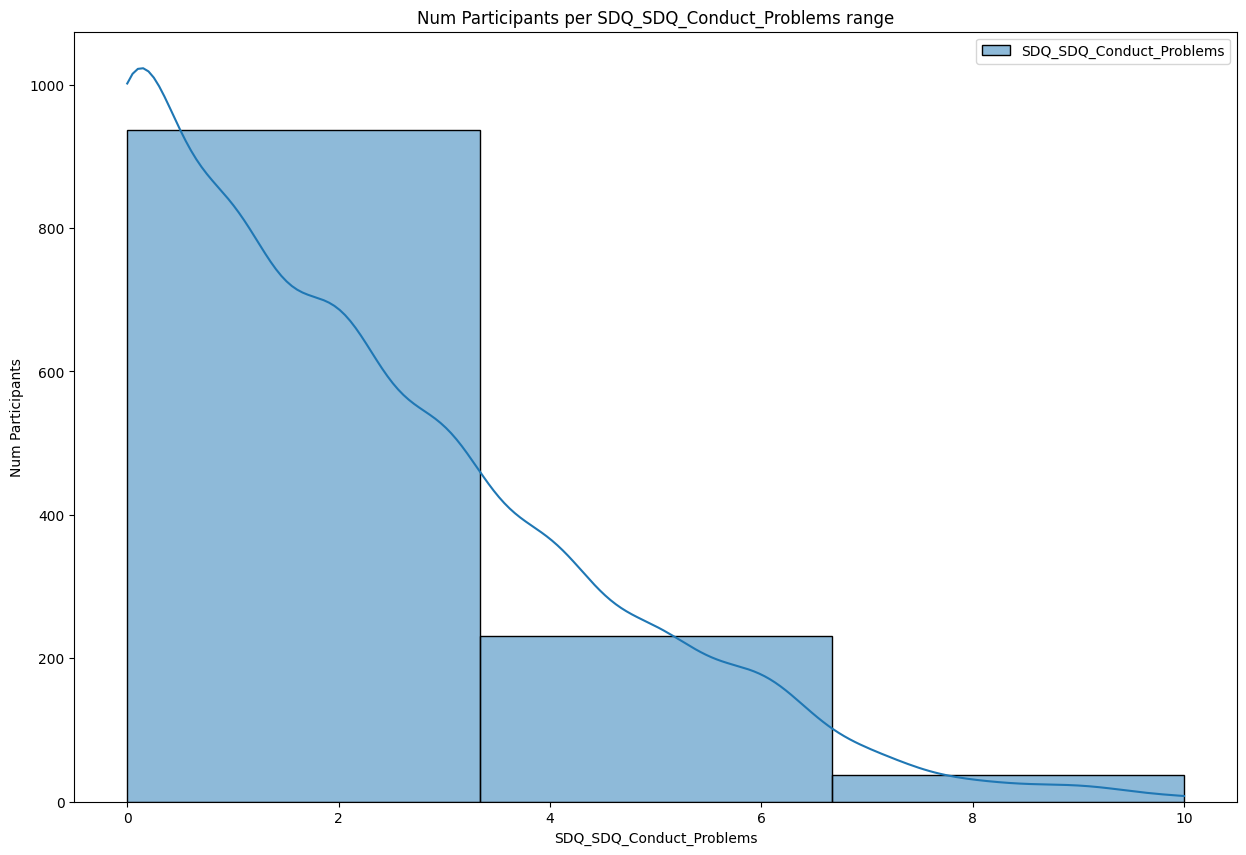

In [ ]:
plt.figure(figsize=(15, 10))
sns.histplot(training_quantitative[['SDQ_SDQ_Conduct_Problems']], kde=True, bins=3, alpha=0.5)
plt.title("Num Participants per SDQ_SDQ_Conduct_Problems range")
plt.ylabel("Num Participants")
plt.xlabel("SDQ_SDQ_Conduct_Problems")
plt.show()

In [ ]:
training_quantitative = training_quantitative.drop(['SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Internalizing'], axis=1)

In [ ]:
training_quantitative.loc[training_quantitative['SDQ_SDQ_Conduct_Problems'].isnull(), 'SDQ_SDQ_Conduct_Problems'] = training_quantitative['SDQ_SDQ_Conduct_Problems'].median()

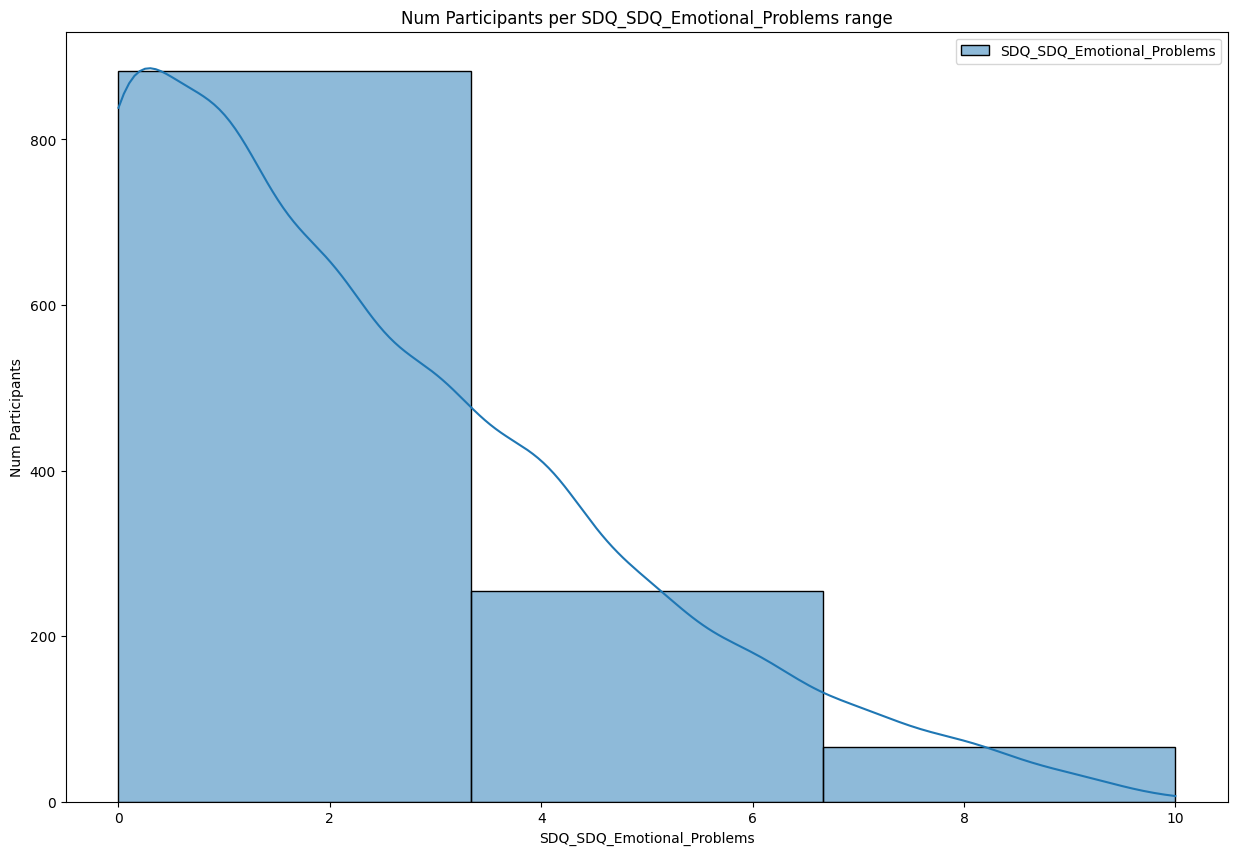

In [ ]:
plt.figure(figsize=(15, 10))
sns.histplot(training_quantitative[['SDQ_SDQ_Emotional_Problems']], kde=True, bins=3, alpha=0.5)
plt.title("Num Participants per SDQ_SDQ_Emotional_Problems range")
plt.ylabel("Num Participants")
plt.xlabel("SDQ_SDQ_Emotional_Problems")
plt.show()

In [ ]:
training_quantitative.loc[training_quantitative['SDQ_SDQ_Emotional_Problems'].isnull(), 'SDQ_SDQ_Emotional_Problems'] = training_quantitative['SDQ_SDQ_Emotional_Problems'].median()

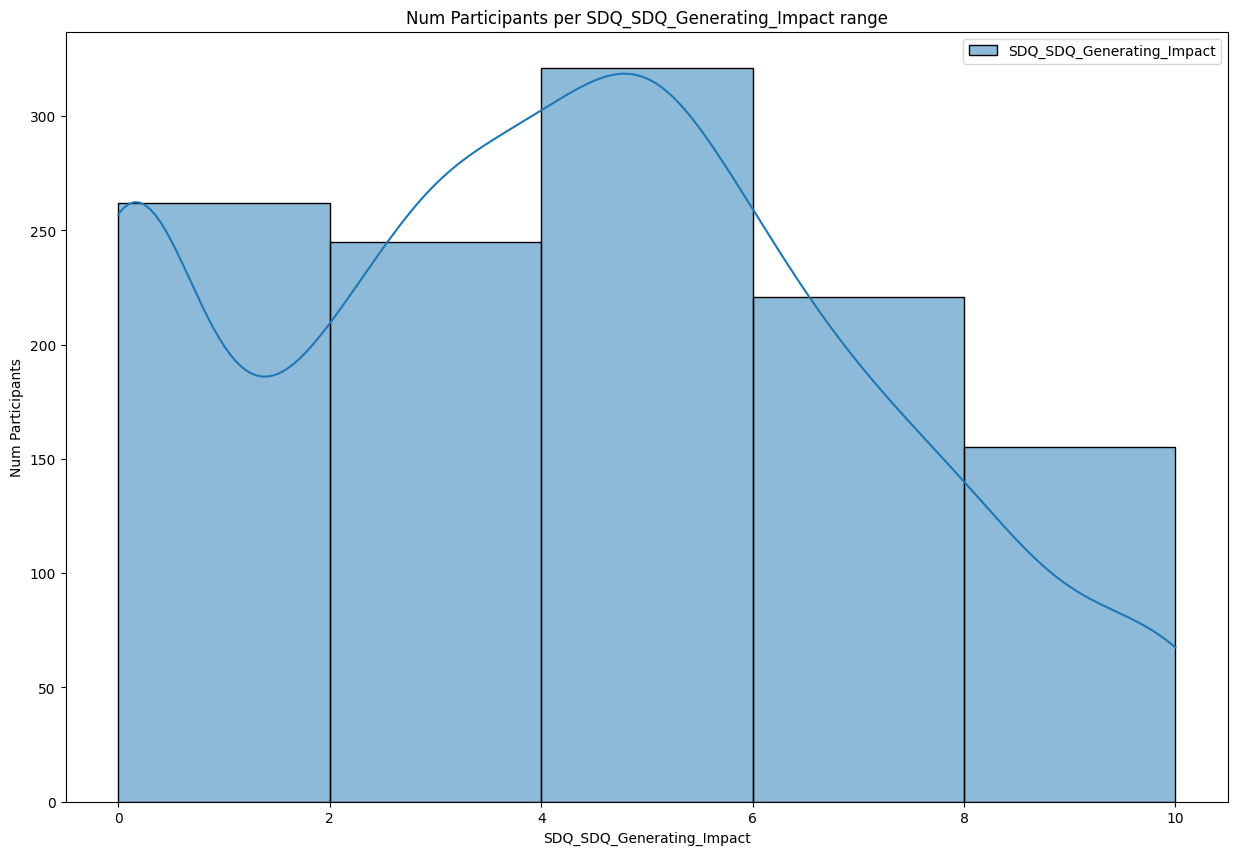

In [ ]:
plt.figure(figsize=(15, 10))
sns.histplot(training_quantitative[['SDQ_SDQ_Generating_Impact']], kde=True, bins=5, alpha=0.5)
plt.title("Num Participants per SDQ_SDQ_Generating_Impact range")
plt.ylabel("Num Participants")
plt.xlabel("SDQ_SDQ_Generating_Impact")
plt.show()

In [ ]:
training_quantitative.loc[training_quantitative['SDQ_SDQ_Generating_Impact'].isnull(), 'SDQ_SDQ_Generating_Impact'] = training_quantitative['SDQ_SDQ_Generating_Impact'].median()

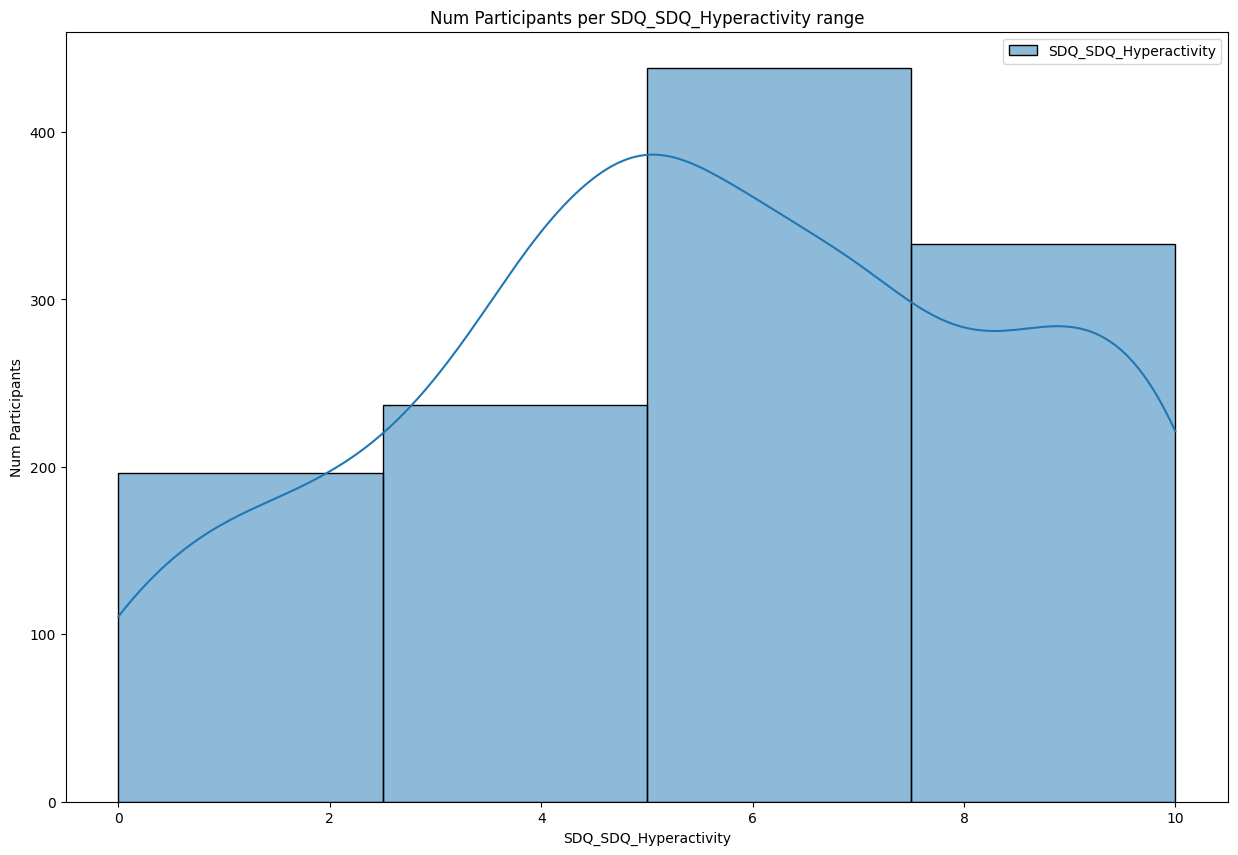

In [ ]:
plt.figure(figsize=(15, 10))
sns.histplot(training_quantitative[['SDQ_SDQ_Hyperactivity']], kde=True, bins=4, alpha=0.5)
plt.title("Num Participants per SDQ_SDQ_Hyperactivity range")
plt.ylabel("Num Participants")
plt.xlabel("SDQ_SDQ_Hyperactivity")
plt.show()

In [ ]:
training_quantitative.loc[training_quantitative['SDQ_SDQ_Hyperactivity'].isnull(), 'SDQ_SDQ_Hyperactivity'] = training_quantitative['SDQ_SDQ_Hyperactivity'].median()

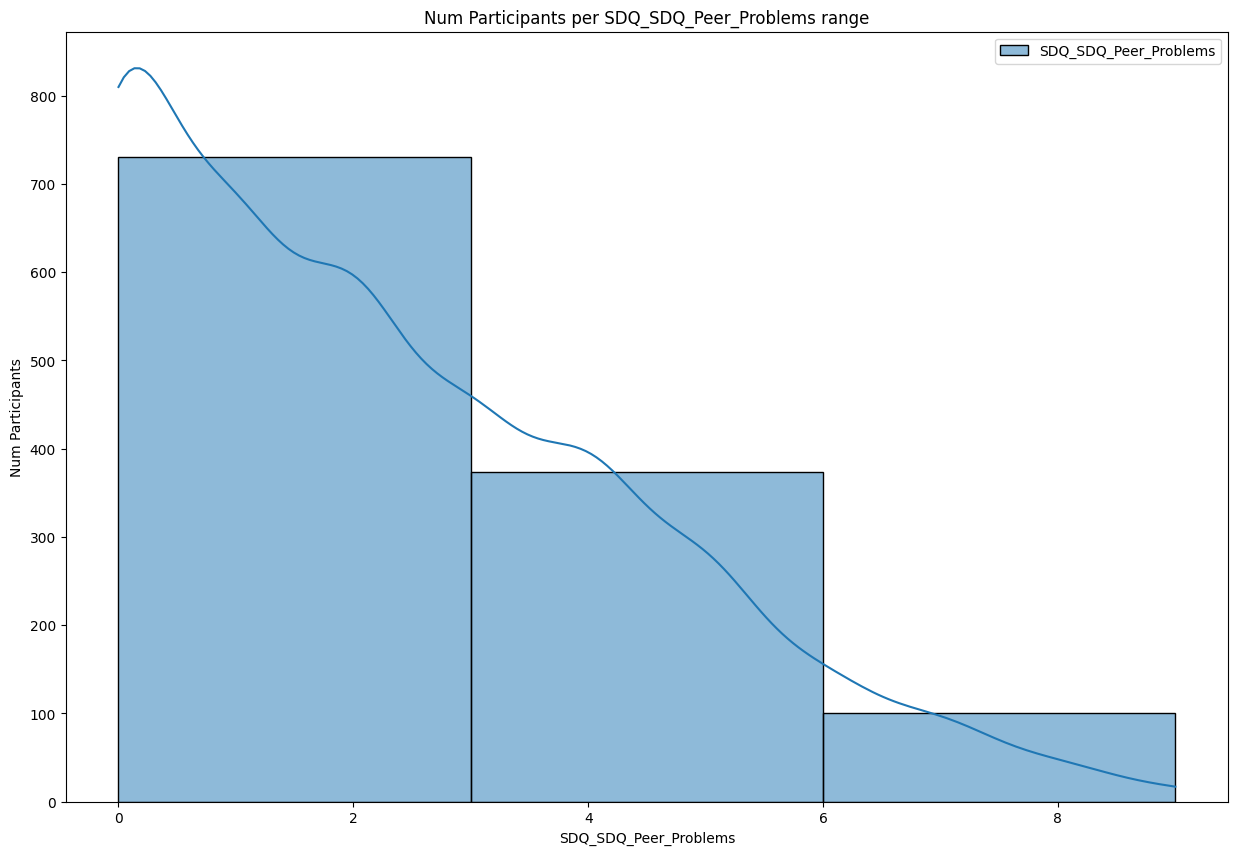

In [ ]:
plt.figure(figsize=(15, 10))
sns.histplot(training_quantitative[['SDQ_SDQ_Peer_Problems']], kde=True, bins=3, alpha=0.5)
plt.title("Num Participants per SDQ_SDQ_Peer_Problems range")
plt.ylabel("Num Participants")
plt.xlabel("SDQ_SDQ_Peer_Problems")
plt.show()

In [ ]:
training_quantitative.loc[training_quantitative['SDQ_SDQ_Peer_Problems'].isnull(), 'SDQ_SDQ_Peer_Problems'] = training_quantitative['SDQ_SDQ_Peer_Problems'].median()

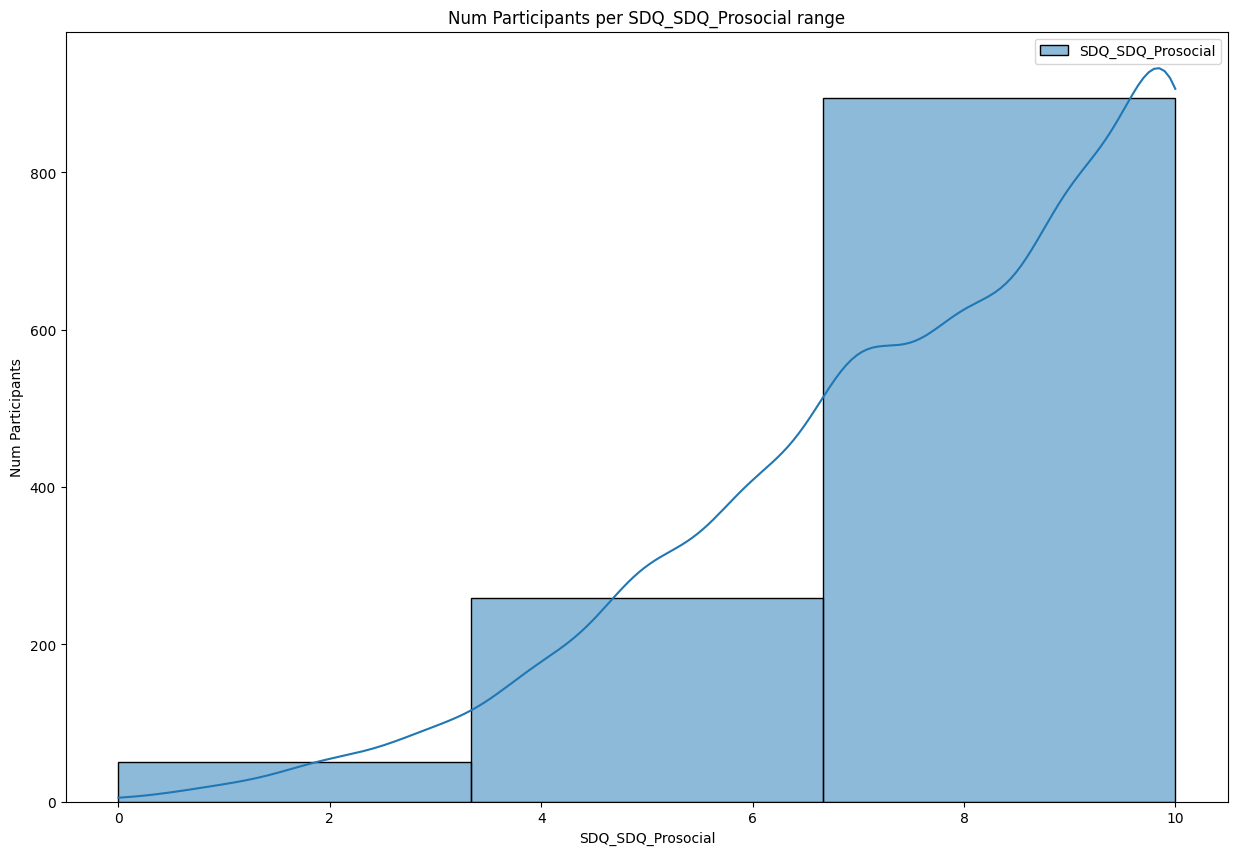

In [ ]:
plt.figure(figsize=(15, 10))
sns.histplot(training_quantitative[['SDQ_SDQ_Prosocial']], kde=True, bins=3, alpha=0.5)
plt.title("Num Participants per SDQ_SDQ_Prosocial range")
plt.ylabel("Num Participants")
plt.xlabel("SDQ_SDQ_Prosocial")
plt.show()

In [ ]:
training_quantitative.loc[training_quantitative['SDQ_SDQ_Prosocial'].isnull(), 'SDQ_SDQ_Prosocial'] = training_quantitative['SDQ_SDQ_Prosocial'].median()

## **Modeling**

In [ ]:
quant_and_cat = train_categorical.join(training_quantitative.set_index('participant_id'), on='participant_id')
train_total = quant_and_cat.join(train_functional.set_index('participant_id'), on='participant_id')
train_total

,participant_id,Basic_Demos_Enroll_Year,One_Parent,No_Parent,Harlem,MRV,Midtown,Staten Island_Study,SI RUMC,Decline to specify,...,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
0,00aIpNTbG5uh,2019,0,0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.047477,-0.096450,-0.280312,0.037560,0.423037,0.242453,0.336213,0.402338,0.327915,0.539032
1,00fV0OyyoLfw,2017,0,0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.143218,-0.276464,-0.332783,-0.332711,0.556939,0.475578,0.429196,0.457970,0.312571,0.595978
2,04X1eiS79T4B,2017,0,0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.133778,-0.108588,-0.002132,-0.175586,0.679183,0.290292,0.486680,0.255208,0.575017,0.605182
3,05ocQutkURd6,2018,0,0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.096647,-0.041420,-0.199576,-0.216457,0.519074,0.298586,0.415466,0.511607,0.361204,0.446613
4,06YUNBA9ZRLq,2018,0,0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.158995,-0.274017,-0.141012,-0.002865,0.515169,0.336139,0.316430,0.442230,0.177079,0.378278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1208,zwjJWCRzKhDz,2019,0,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.157897,0.122978,0.112789,0.211312,0.601190,0.587116,0.312695,0.485938,0.189102,0.354333
1209,zwXD5v17Rx01,2018,0,0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.343204,0.198827,0.253990,0.198741,0.648260,0.055241,0.491985,0.118676,0.404331,0.537121
1210,zWzLCi3NTBTd,2018,0,0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.110834,-0.002346,0.044653,0.234887,0.538475,0.024265,0.472322,0.095624,0.205326,0.182633
1211,Zy9GTHDxUbXU,2019,0,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.013906,0.146094,-0.035955,-0.062152,0.706214,0.183288,0.104987,0.420463,0.152727,0.706737


In [ ]:
for col in train_total.columns:
  if train_total[col].isnull().sum() > 0:
    print(col)

In [ ]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

def multi_output_f1(y_true, y_pred):
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)

  sum_f1 = 0
  for i in range(y_true.shape[1]):
    sum_f1 += f1_score(y_true[:, i], y_pred[:, i])

  return np.mean(sum_f1)

In [ ]:
scorer = make_scorer(multi_output_f1)

In [ ]:
param = {
    'classifier__estimator__C': [0.5, 1, 1.5],
    'classifier__estimator__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'pca__n_components': list(range(100, 600, 200))
}

classifier = MultiOutputClassifier(SVC())
scaler = StandardScaler()
pca = PCA()
pipeline = Pipeline([('scaler', scaler), ('pca', pca), ('classifier', classifier)])
grid_search = RandomizedSearchCV(pipeline, param, cv=5, scoring=scorer, n_jobs=4, error_score='raise')
csv = cross_val_score(grid_search, train_total.drop('participant_id', axis=1), training_solutions.drop('participant_id', axis=1), cv=5, scoring=scorer)
csv.mean()

KeyboardInterrupt: 

In [ ]:
random_search_SVM = RandomizedSearchCV(pipeline, param, cv = 5, scoring=scorer)
random_search_SVM.fit(train_total.drop('participant_id', axis=1), training_solutions.drop('participant_id', axis=1))

print(random_search_SVM.best_params_)
print("SVM Best Params Score ", (random_search_SVM.best_score_ * 100))

## **Clean Test Set**

In [ ]:
%cd ..
%cd TEST

/content/drive/MyDrive/widsdatathon2025
/content/drive/MyDrive/widsdatathon2025/TEST


In [ ]:
test_categorical = pd.read_excel('TEST_CATEGORICAL.xlsx')
test_functional = pd.read_csv('TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv')
test_quantitative = pd.read_excel('TEST_QUANTITATIVE_METADATA.xlsx')

In [ ]:
def check_nulls(df):
  for col in df.columns:
    if df[col].isnull().sum() > 0:
      print(col)

check_nulls(test_categorical)
check_nulls(test_functional)
check_nulls(test_quantitative)

PreInt_Demos_Fam_Child_Ethnicity
PreInt_Demos_Fam_Child_Race
Barratt_Barratt_P1_Edu
Barratt_Barratt_P1_Occ
Barratt_Barratt_P2_Edu
Barratt_Barratt_P2_Occ
EHQ_EHQ_Total
ColorVision_CV_Score
APQ_P_APQ_P_CP
APQ_P_APQ_P_ID
APQ_P_APQ_P_INV
APQ_P_APQ_P_OPD
APQ_P_APQ_P_PM
APQ_P_APQ_P_PP
SDQ_SDQ_Conduct_Problems
SDQ_SDQ_Difficulties_Total
SDQ_SDQ_Emotional_Problems
SDQ_SDQ_Externalizing
SDQ_SDQ_Generating_Impact
SDQ_SDQ_Hyperactivity
SDQ_SDQ_Internalizing
SDQ_SDQ_Peer_Problems
SDQ_SDQ_Prosocial


In [ ]:
test_categorical.loc[:, 'One_Parent'] = 0
test_categorical.loc[:, 'No_Parent'] = 0
for index, row in test_categorical.iterrows():
  if pd.isna(row['Barratt_Barratt_P1_Edu']) and pd.isna(row['Barratt_Barratt_P1_Occ']) and pd.isna(row['Barratt_Barratt_P2_Edu']) and pd.isna(row['Barratt_Barratt_P2_Occ']):
    test_categorical.loc[index, 'Barratt_Barratt_P1_Edu'] = -1.0
    test_categorical.loc[index, 'Barratt_Barratt_P1_Occ'] = -1.0
    test_categorical.loc[index, 'Barratt_Barratt_P2_Edu'] = -1.0
    test_categorical.loc[index, 'Barratt_Barratt_P2_Occ'] = -1.0
    test_categorical.loc[index, 'No_Parent'] = 1
  else:
    if pd.isna(row['Barratt_Barratt_P1_Edu']) and pd.notnull(row['Barratt_Barratt_P1_Occ']):
      cur = test_categorical.loc[(test_categorical['Barratt_Barratt_P1_Occ'] == row['Barratt_Barratt_P1_Occ']), 'Barratt_Barratt_P1_Edu'].mode()[0]
      test_categorical.loc[index, 'Barratt_Barratt_P1_Edu'] = cur
    if pd.isna(row['Barratt_Barratt_P2_Edu']) and pd.notnull(row['Barratt_Barratt_P2_Occ']):
      cur = test_categorical.loc[(test_categorical['Barratt_Barratt_P2_Occ'] == row['Barratt_Barratt_P2_Occ']), 'Barratt_Barratt_P2_Edu'].mode()[0] #if len(test_categorical.loc[(test_categorical['Barratt_Barratt_P2_Occ'] == row['Barratt_Barratt_P2_Occ']), 'Barratt_Barratt_P2_Edu'].mode()) > 0 else -1.0
      test_categorical.loc[index, 'Barratt_Barratt_P2_Edu'] = cur
    if pd.isna(row['Barratt_Barratt_P1_Occ']) and pd.notnull(row['Barratt_Barratt_P1_Edu']):
      cur = test_categorical.loc[(test_categorical['Barratt_Barratt_P1_Edu'] == row['Barratt_Barratt_P1_Edu']), 'Barratt_Barratt_P1_Occ'].mode()[0]
      test_categorical.loc[index, 'Barratt_Barratt_P1_Occ'] = cur
    if pd.isna(row['Barratt_Barratt_P2_Occ']) and pd.notnull(row['Barratt_Barratt_P2_Edu']):
      cur = test_categorical.loc[(test_categorical['Barratt_Barratt_P2_Edu'] == row['Barratt_Barratt_P2_Edu']), 'Barratt_Barratt_P2_Occ'].mode()[0]
      test_categorical.loc[index, 'Barratt_Barratt_P2_Occ'] = cur
    if pd.isna(row['Barratt_Barratt_P1_Edu']) and pd.isna(row['Barratt_Barratt_P1_Occ']):
      test_categorical.loc[index, 'Barratt_Barratt_P1_Edu'] = -1.0
      test_categorical.loc[index, 'Barratt_Barratt_P1_Occ'] = -1.0
      test_categorical.loc[index, 'One_Parent'] = 1
    if pd.isna(row['Barratt_Barratt_P2_Edu']) and pd.isna(row['Barratt_Barratt_P2_Occ']):
      test_categorical.loc[index, 'Barratt_Barratt_P2_Edu'] = -1.0
      test_categorical.loc[index, 'Barratt_Barratt_P2_Occ'] = -1.0
      test_categorical.loc[index, 'One_Parent'] = 1

In [ ]:
test_categorical.loc[test_categorical['PreInt_Demos_Fam_Child_Ethnicity'].isna(), ['PreInt_Demos_Fam_Child_Ethnicity']] = 3.0
test_categorical.loc[test_categorical['PreInt_Demos_Fam_Child_Race'].isna(), ['PreInt_Demos_Fam_Child_Race']] = 10.0
test_categorical.loc[test_categorical['MRI_Track_Scan_Location'].isna(), ['MRI_Track_Scan_Location']] = test_categorical['MRI_Track_Scan_Location'].mode()[0]

In [ ]:
test_quantitative.loc[test_quantitative['MRI_Track_Age_at_Scan'].isna(), ['MRI_Track_Age_at_Scan']] = test_quantitative['MRI_Track_Age_at_Scan'].mean()
test_quantitative.loc[test_quantitative['EHQ_EHQ_Total'].isnull(), 'EHQ_EHQ_Total'] = test_quantitative['EHQ_EHQ_Total'].describe().iloc[5]
test_quantitative.loc[test_quantitative['ColorVision_CV_Score'].isnull(), 'ColorVision_CV_Score'] = test_quantitative['ColorVision_CV_Score'].median()
test_quantitative.loc[test_quantitative['APQ_P_APQ_P_CP'].isnull(), 'APQ_P_APQ_P_CP'] = test_quantitative['APQ_P_APQ_P_CP'].median()
test_quantitative.loc[test_quantitative['APQ_P_APQ_P_ID'].isnull(), 'APQ_P_APQ_P_ID'] = test_quantitative['APQ_P_APQ_P_ID'].median()
test_quantitative.loc[test_quantitative['APQ_P_APQ_P_INV'].isnull(), 'APQ_P_APQ_P_INV'] = test_quantitative['APQ_P_APQ_P_INV'].median()
test_quantitative.loc[test_quantitative['APQ_P_APQ_P_OPD'].isnull(), 'APQ_P_APQ_P_OPD'] = test_quantitative['APQ_P_APQ_P_OPD'].median()
test_quantitative.loc[test_quantitative['APQ_P_APQ_P_PM'].isnull(), 'APQ_P_APQ_P_PM'] = test_quantitative['APQ_P_APQ_P_PM'].median()
test_quantitative.loc[test_quantitative['APQ_P_APQ_P_PP'].isnull(), 'APQ_P_APQ_P_PP'] = test_quantitative['APQ_P_APQ_P_PP'].median()
test_quantitative.loc[test_quantitative['SDQ_SDQ_Conduct_Problems'].isnull(), 'SDQ_SDQ_Conduct_Problems'] = test_quantitative['SDQ_SDQ_Conduct_Problems'].median()
test_quantitative.loc[test_quantitative['SDQ_SDQ_Difficulties_Total'].isnull(), 'SDQ_SDQ_Difficulties_Total'] = test_quantitative['SDQ_SDQ_Difficulties_Total'].median()
test_quantitative.loc[test_quantitative['SDQ_SDQ_Emotional_Problems'].isnull(), 'SDQ_SDQ_Emotional_Problems'] = test_quantitative['SDQ_SDQ_Emotional_Problems'].median()
test_quantitative.loc[test_quantitative['SDQ_SDQ_Externalizing'].isnull(), 'SDQ_SDQ_Externalizing'] = test_quantitative['SDQ_SDQ_Externalizing'].median()
test_quantitative.loc[test_quantitative['SDQ_SDQ_Generating_Impact'].isnull(), 'SDQ_SDQ_Generating_Impact'] = test_quantitative['SDQ_SDQ_Generating_Impact'].median()
test_quantitative.loc[test_quantitative['SDQ_SDQ_Hyperactivity'].isnull(), 'SDQ_SDQ_Hyperactivity'] = test_quantitative['SDQ_SDQ_Hyperactivity'].median()
test_quantitative.loc[test_quantitative['SDQ_SDQ_Internalizing'].isnull(), 'SDQ_SDQ_Internalizing'] = test_quantitative['SDQ_SDQ_Internalizing'].median()
test_quantitative.loc[test_quantitative['SDQ_SDQ_Peer_Problems'].isnull(), 'SDQ_SDQ_Peer_Problems'] = test_quantitative['SDQ_SDQ_Peer_Problems'].median()
test_quantitative.loc[test_quantitative['SDQ_SDQ_Prosocial'].isnull(), 'SDQ_SDQ_Prosocial'] = test_quantitative['SDQ_SDQ_Prosocial'].median()

In [ ]:
test_categorical['Basic_Demos_Study_Site'] = test_categorical['Basic_Demos_Study_Site'].astype(object)
test_categorical.loc[test_categorical['Basic_Demos_Study_Site'] == 1, 'Basic_Demos_Study_Site'] = 'Staten Island_Study'
test_categorical.loc[test_categorical['Basic_Demos_Study_Site'] == 2, 'Basic_Demos_Study_Site'] = 'MRV'
test_categorical.loc[test_categorical['Basic_Demos_Study_Site'] == 3, 'Basic_Demos_Study_Site'] = 'Midtown'
test_categorical.loc[test_categorical['Basic_Demos_Study_Site'] == 4, 'Basic_Demos_Study_Site'] = 'Harlem'
test_categorical.loc[test_categorical['Basic_Demos_Study_Site'] == 5, 'Basic_Demos_Study_Site'] = 'SI RUMC'
test_categorical = test_categorical.join(pd.get_dummies(test_categorical['Basic_Demos_Study_Site'], dtype=float), lsuffix='_drop')
test_categorical.loc[:, ['Staten Island_Study']] = 0.0
test_categorical.loc[:, ['MRV']] = 0.0
test_categorical.loc[:, ['Midtown']] = 0.0
test_categorical = test_categorical.drop(['Basic_Demos_Study_Site'], axis=1)
test_categorical.head()

,participant_id,Basic_Demos_Enroll_Year,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,One_Parent,No_Parent,Harlem,SI RUMC,Staten Island_Study,MRV,Midtown
0,Cfwaf5FX7jWK,2022,0.0,0.0,4,21.0,30.0,18.0,30.0,0,0,1.0,0.0,0.0,0.0,0.0
1,vhGrzmvA3Hjq,2023,0.0,0.0,4,21.0,45.0,18.0,30.0,0,0,1.0,0.0,0.0,0.0,0.0
2,ULliyEXjy4OV,2022,0.0,0.0,4,21.0,40.0,18.0,40.0,0,0,1.0,0.0,0.0,0.0,0.0
3,LZfeAb1xMtql,2022,0.0,0.0,3,21.0,45.0,21.0,45.0,0,0,1.0,0.0,0.0,0.0,0.0
4,EnFOUv0YK1RG,2022,2.0,0.0,4,18.0,0.0,21.0,45.0,0,0,1.0,0.0,0.0,0.0,0.0


In [ ]:
test_categorical['PreInt_Demos_Fam_Child_Ethnicity'] = test_categorical['PreInt_Demos_Fam_Child_Ethnicity'].astype(object)
test_categorical.loc[test_categorical['PreInt_Demos_Fam_Child_Ethnicity'] == 0, 'PreInt_Demos_Fam_Child_Ethnicity'] = 'Not Hispanic or Latino'
test_categorical.loc[test_categorical['PreInt_Demos_Fam_Child_Ethnicity'] == 1, 'PreInt_Demos_Fam_Child_Ethnicity'] = 'Hispanic or Latino'
test_categorical.loc[test_categorical['PreInt_Demos_Fam_Child_Ethnicity'] == 2, 'PreInt_Demos_Fam_Child_Ethnicity'] = 'Decline to specify'
test_categorical.loc[test_categorical['PreInt_Demos_Fam_Child_Ethnicity'] == 3, 'PreInt_Demos_Fam_Child_Ethnicity'] = 'Unknown_Eth'
test_categorical = test_categorical.join(pd.get_dummies(test_categorical['PreInt_Demos_Fam_Child_Ethnicity'], dtype=float))
test_categorical = test_categorical.drop(['PreInt_Demos_Fam_Child_Ethnicity'], axis=1)
test_categorical.head()

,participant_id,Basic_Demos_Enroll_Year,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,One_Parent,No_Parent,Harlem,SI RUMC,Staten Island_Study,MRV,Midtown,Decline to specify,Hispanic or Latino,Not Hispanic or Latino,Unknown_Eth
0,Cfwaf5FX7jWK,2022,0.0,4,21.0,30.0,18.0,30.0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,vhGrzmvA3Hjq,2023,0.0,4,21.0,45.0,18.0,30.0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,ULliyEXjy4OV,2022,0.0,4,21.0,40.0,18.0,40.0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,LZfeAb1xMtql,2022,0.0,3,21.0,45.0,21.0,45.0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,EnFOUv0YK1RG,2022,0.0,4,18.0,0.0,21.0,45.0,0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
test_categorical['PreInt_Demos_Fam_Child_Race'] = test_categorical['PreInt_Demos_Fam_Child_Race'].astype(object)
test_categorical.loc[test_categorical['PreInt_Demos_Fam_Child_Race'] == 0, 'PreInt_Demos_Fam_Child_Race'] = 'White/Caucasian'
test_categorical.loc[test_categorical['PreInt_Demos_Fam_Child_Race'] == 1, 'PreInt_Demos_Fam_Child_Race'] = 'Black/African_American'
test_categorical.loc[test_categorical['PreInt_Demos_Fam_Child_Race'] == 2, 'PreInt_Demos_Fam_Child_Race'] = 'Hispanic'
test_categorical.loc[test_categorical['PreInt_Demos_Fam_Child_Race'] == 3, 'PreInt_Demos_Fam_Child_Race'] = 'Asia'
test_categorical.loc[test_categorical['PreInt_Demos_Fam_Child_Race'] == 4, 'PreInt_Demos_Fam_Child_Race'] = 'Indian'
test_categorical.loc[test_categorical['PreInt_Demos_Fam_Child_Race'] == 5, 'PreInt_Demos_Fam_Child_Race'] = 'Native_American_Indian'
test_categorical.loc[test_categorical['PreInt_Demos_Fam_Child_Race'] == 6, 'PreInt_Demos_Fam_Child_Race'] = 'American_Indian/Alaskan_Native'
test_categorical.loc[test_categorical['PreInt_Demos_Fam_Child_Race'] == 7, 'PreInt_Demos_Fam_Child_Race'] = 'Native Hawaiian/Other_Pacific_Islander'
test_categorical.loc[test_categorical['PreInt_Demos_Fam_Child_Race'] == 8, 'PreInt_Demos_Fam_Child_Race'] = 'Two_or_more_races'
test_categorical.loc[test_categorical['PreInt_Demos_Fam_Child_Race'] == 9, 'PreInt_Demos_Fam_Child_Race'] = 'Other_race'
test_categorical.loc[test_categorical['PreInt_Demos_Fam_Child_Race'] == 10, 'PreInt_Demos_Fam_Child_Race'] = 'Unknown_Race'
test_categorical.loc[test_categorical['PreInt_Demos_Fam_Child_Race'] == 11, 'PreInt_Demos_Fam_Child_Race'] = 'Choose_not_to_specify'
test_categorical = test_categorical.join(pd.get_dummies(test_categorical['PreInt_Demos_Fam_Child_Race'], dtype=float))
test_categorical.loc[:, ['Native_American_Indian']] = 0.0
test_categorical.loc[:, ['American_Indian/Alaskan_Native']] = 0.0
test_categorical = test_categorical.drop(['PreInt_Demos_Fam_Child_Race'], axis=1)
test_categorical.head()

,participant_id,Basic_Demos_Enroll_Year,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,One_Parent,No_Parent,Harlem,...,Choose_not_to_specify,Hispanic,Indian,Native Hawaiian/Other_Pacific_Islander,Other_race,Two_or_more_races,Unknown_Race,White/Caucasian,Native_American_Indian,American_Indian/Alaskan_Native
0,Cfwaf5FX7jWK,2022,4,21.0,30.0,18.0,30.0,0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,vhGrzmvA3Hjq,2023,4,21.0,45.0,18.0,30.0,0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,ULliyEXjy4OV,2022,4,21.0,40.0,18.0,40.0,0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,LZfeAb1xMtql,2022,3,21.0,45.0,21.0,45.0,0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,EnFOUv0YK1RG,2022,4,18.0,0.0,21.0,45.0,0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
test_categorical['MRI_Track_Scan_Location'] = test_categorical['MRI_Track_Scan_Location'].astype(object)
test_categorical.loc[test_categorical['MRI_Track_Scan_Location'] == 1, 'MRI_Track_Scan_Location'] = 'Staten_Island_Scan'
test_categorical.loc[test_categorical['MRI_Track_Scan_Location'] == 2, 'MRI_Track_Scan_Location'] = 'RUBIC'
test_categorical.loc[test_categorical['MRI_Track_Scan_Location'] == 3, 'MRI_Track_Scan_Location'] = 'CBIC'
test_categorical.loc[test_categorical['MRI_Track_Scan_Location'] == 4, 'MRI_Track_Scan_Location'] = 'CUNY'
test_categorical = test_categorical.join(pd.get_dummies(test_categorical['MRI_Track_Scan_Location'], dtype=float))
test_categorical.loc[:, ['Staten_Island_Scan']] = 0.0
test_categorical.loc[:, ['RUBIC']] = 0.0
test_categorical = test_categorical.drop(['MRI_Track_Scan_Location'], axis=1)
test_categorical.head()

,participant_id,Basic_Demos_Enroll_Year,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,One_Parent,No_Parent,Harlem,SI RUMC,...,Other_race,Two_or_more_races,Unknown_Race,White/Caucasian,Native_American_Indian,American_Indian/Alaskan_Native,CBIC,CUNY,Staten_Island_Scan,RUBIC
0,Cfwaf5FX7jWK,2022,21.0,30.0,18.0,30.0,0,0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,vhGrzmvA3Hjq,2023,21.0,45.0,18.0,30.0,0,0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,ULliyEXjy4OV,2022,21.0,40.0,18.0,40.0,0,0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,LZfeAb1xMtql,2022,21.0,45.0,21.0,45.0,0,0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,EnFOUv0YK1RG,2022,18.0,0.0,21.0,45.0,0,0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
test_categorical['Barratt_Barratt_P1_Edu'] = test_categorical['Barratt_Barratt_P1_Edu'].astype(object)
test_categorical.loc[test_categorical['Barratt_Barratt_P1_Edu'] == -1, 'Barratt_Barratt_P1_Edu'] = 'P1_Unknown_Edu'
test_categorical.loc[test_categorical['Barratt_Barratt_P1_Edu'] == 3, 'Barratt_Barratt_P1_Edu'] = 'P1_<7th_grade'
test_categorical.loc[test_categorical['Barratt_Barratt_P1_Edu'] == 6, 'Barratt_Barratt_P1_Edu'] = 'P1_9th_grade'
test_categorical.loc[test_categorical['Barratt_Barratt_P1_Edu'] == 9, 'Barratt_Barratt_P1_Edu'] = 'P1_10th/11th_grade'
test_categorical.loc[test_categorical['Barratt_Barratt_P1_Edu'] == 12, 'Barratt_Barratt_P1_Edu'] = 'P1_HS_Grade'
test_categorical.loc[test_categorical['Barratt_Barratt_P1_Edu'] == 15, 'Barratt_Barratt_P1_Edu'] = 'P1_Partial_College'
test_categorical.loc[test_categorical['Barratt_Barratt_P1_Edu'] == 18, 'Barratt_Barratt_P1_Edu'] = 'P1_College_Ed'
test_categorical.loc[test_categorical['Barratt_Barratt_P1_Edu'] == 21, 'Barratt_Barratt_P1_Edu'] = 'P1_Grad_Degree'
test_categorical = test_categorical.join(pd.get_dummies(test_categorical['Barratt_Barratt_P1_Edu'], dtype=float))
test_categorical = test_categorical.drop(['Barratt_Barratt_P1_Edu'], axis=1)
test_categorical.head()

,participant_id,Basic_Demos_Enroll_Year,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,One_Parent,No_Parent,Harlem,SI RUMC,Staten Island_Study,...,Staten_Island_Scan,RUBIC,P1_10th/11th_grade,P1_9th_grade,P1_<7th_grade,P1_College_Ed,P1_Grad_Degree,P1_HS_Grade,P1_Partial_College,P1_Unknown_Edu
0,Cfwaf5FX7jWK,2022,30.0,18.0,30.0,0,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,vhGrzmvA3Hjq,2023,45.0,18.0,30.0,0,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,ULliyEXjy4OV,2022,40.0,18.0,40.0,0,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,LZfeAb1xMtql,2022,45.0,21.0,45.0,0,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,EnFOUv0YK1RG,2022,0.0,21.0,45.0,0,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
test_categorical['Barratt_Barratt_P2_Edu'] = test_categorical['Barratt_Barratt_P2_Edu'].astype(object)
test_categorical.loc[test_categorical['Barratt_Barratt_P2_Edu'] == -1, 'Barratt_Barratt_P2_Edu'] = 'P2_Unknown_Edu'
test_categorical.loc[test_categorical['Barratt_Barratt_P2_Edu'] == 3, 'Barratt_Barratt_P2_Edu'] = 'P2_<7th_grade'
test_categorical.loc[test_categorical['Barratt_Barratt_P2_Edu'] == 6, 'Barratt_Barratt_P2_Edu'] = 'P2_9th_grade'
test_categorical.loc[test_categorical['Barratt_Barratt_P2_Edu'] == 9, 'Barratt_Barratt_P2_Edu'] = 'P2_10th/11th_grade'
test_categorical.loc[test_categorical['Barratt_Barratt_P2_Edu'] == 12, 'Barratt_Barratt_P2_Edu'] = 'P2_HS_Grade'
test_categorical.loc[test_categorical['Barratt_Barratt_P2_Edu'] == 15, 'Barratt_Barratt_P2_Edu'] = 'P2_Partial_College'
test_categorical.loc[test_categorical['Barratt_Barratt_P2_Edu'] == 18, 'Barratt_Barratt_P2_Edu'] = 'P2_College_Ed'
test_categorical.loc[test_categorical['Barratt_Barratt_P2_Edu'] == 21, 'Barratt_Barratt_P2_Edu'] = 'P2_Grad_Degree'
test_categorical = test_categorical.join(pd.get_dummies(test_categorical['Barratt_Barratt_P2_Edu'], dtype=float))
test_categorical = test_categorical.drop(['Barratt_Barratt_P2_Edu'], axis=1)
test_categorical.head()

,participant_id,Basic_Demos_Enroll_Year,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Occ,One_Parent,No_Parent,Harlem,SI RUMC,Staten Island_Study,MRV,...,P1_Partial_College,P1_Unknown_Edu,P2_10th/11th_grade,P2_9th_grade,P2_<7th_grade,P2_College_Ed,P2_Grad_Degree,P2_HS_Grade,P2_Partial_College,P2_Unknown_Edu
0,Cfwaf5FX7jWK,2022,30.0,30.0,0,0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,vhGrzmvA3Hjq,2023,45.0,30.0,0,0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,ULliyEXjy4OV,2022,40.0,40.0,0,0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,LZfeAb1xMtql,2022,45.0,45.0,0,0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,EnFOUv0YK1RG,2022,0.0,45.0,0,0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
test_categorical['Barratt_Barratt_P1_Occ'] = test_categorical['Barratt_Barratt_P1_Occ'].astype(object)
test_categorical.loc[test_categorical['Barratt_Barratt_P1_Occ'] == -1, 'Barratt_Barratt_P1_Occ'] = 'P1_Unknown_Occ'
test_categorical.loc[test_categorical['Barratt_Barratt_P1_Occ'] == 0, 'Barratt_Barratt_P1_Occ'] = 'P1_Unemployed'
test_categorical.loc[test_categorical['Barratt_Barratt_P1_Occ'] == 5, 'Barratt_Barratt_P1_Occ'] = 'P1_Unskilled'
test_categorical.loc[test_categorical['Barratt_Barratt_P1_Occ'] == 10, 'Barratt_Barratt_P1_Occ'] = 'P1_Semi-skilled'
test_categorical.loc[test_categorical['Barratt_Barratt_P1_Occ'] == 15, 'Barratt_Barratt_P1_Occ'] = 'P1_Skilled'
test_categorical.loc[test_categorical['Barratt_Barratt_P1_Occ'] == 20, 'Barratt_Barratt_P1_Occ'] = 'P1_Clerical'
test_categorical.loc[test_categorical['Barratt_Barratt_P1_Occ'] == 25, 'Barratt_Barratt_P1_Occ'] = 'P1_Technical'
test_categorical.loc[test_categorical['Barratt_Barratt_P1_Occ'] == 30, 'Barratt_Barratt_P1_Occ'] = 'P1_Semi-professional'
test_categorical.loc[test_categorical['Barratt_Barratt_P1_Occ'] == 35, 'Barratt_Barratt_P1_Occ'] = 'P1_Professional'
test_categorical.loc[test_categorical['Barratt_Barratt_P1_Occ'] == 40, 'Barratt_Barratt_P1_Occ'] = 'P1_Executive'
test_categorical.loc[test_categorical['Barratt_Barratt_P1_Occ'] == 45, 'Barratt_Barratt_P1_Occ'] = 'P1_Elite'
test_categorical = test_categorical.join(pd.get_dummies(test_categorical['Barratt_Barratt_P1_Occ'], dtype=float))
test_categorical.loc[:, ['P1_Semi-skilled']] = 0.0
test_categorical = test_categorical.drop(['Barratt_Barratt_P1_Occ'], axis=1)
test_categorical.head()

,participant_id,Basic_Demos_Enroll_Year,Barratt_Barratt_P2_Occ,One_Parent,No_Parent,Harlem,SI RUMC,Staten Island_Study,MRV,Midtown,...,P1_Elite,P1_Executive,P1_Professional,P1_Semi-professional,P1_Skilled,P1_Technical,P1_Unemployed,P1_Unknown_Occ,P1_Unskilled,P1_Semi-skilled
0,Cfwaf5FX7jWK,2022,30.0,0,0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,vhGrzmvA3Hjq,2023,30.0,0,0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ULliyEXjy4OV,2022,40.0,0,0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,LZfeAb1xMtql,2022,45.0,0,0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,EnFOUv0YK1RG,2022,45.0,0,0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
test_categorical['Barratt_Barratt_P2_Occ'] = test_categorical['Barratt_Barratt_P2_Occ'].astype(object)
test_categorical.loc[test_categorical['Barratt_Barratt_P2_Occ'] == -1, 'Barratt_Barratt_P2_Occ'] = 'P2_Unknown_Occ'
test_categorical.loc[test_categorical['Barratt_Barratt_P2_Occ'] == 0, 'Barratt_Barratt_P2_Occ'] = 'P2_Unemployed'
test_categorical.loc[test_categorical['Barratt_Barratt_P2_Occ'] == 5, 'Barratt_Barratt_P2_Occ'] = 'P2_Unskilled'
test_categorical.loc[test_categorical['Barratt_Barratt_P2_Occ'] == 10, 'Barratt_Barratt_P2_Occ'] = 'P2_Semi-skilled'
test_categorical.loc[test_categorical['Barratt_Barratt_P2_Occ'] == 15, 'Barratt_Barratt_P2_Occ'] = 'P2_Skilled'
test_categorical.loc[test_categorical['Barratt_Barratt_P2_Occ'] == 20, 'Barratt_Barratt_P2_Occ'] = 'P2_Clerical'
test_categorical.loc[test_categorical['Barratt_Barratt_P2_Occ'] == 25, 'Barratt_Barratt_P2_Occ'] = 'P2_Technical'
test_categorical.loc[test_categorical['Barratt_Barratt_P2_Occ'] == 30, 'Barratt_Barratt_P2_Occ'] = 'P2_Semi-professional'
test_categorical.loc[test_categorical['Barratt_Barratt_P2_Occ'] == 35, 'Barratt_Barratt_P2_Occ'] = 'P2_Professional'
test_categorical.loc[test_categorical['Barratt_Barratt_P2_Occ'] == 40, 'Barratt_Barratt_P2_Occ'] = 'P2_Executive'
test_categorical.loc[test_categorical['Barratt_Barratt_P2_Occ'] == 45, 'Barratt_Barratt_P2_Occ'] = 'P2_Elite'
test_categorical = test_categorical.join(pd.get_dummies(test_categorical['Barratt_Barratt_P2_Occ'], dtype=float))
test_categorical = test_categorical.drop(['Barratt_Barratt_P2_Occ'], axis=1)
test_categorical.head()

,participant_id,Basic_Demos_Enroll_Year,One_Parent,No_Parent,Harlem,SI RUMC,Staten Island_Study,MRV,Midtown,Decline to specify,...,P2_Elite,P2_Executive,P2_Professional,P2_Semi-professional,P2_Semi-skilled,P2_Skilled,P2_Technical,P2_Unemployed,P2_Unknown_Occ,P2_Unskilled
0,Cfwaf5FX7jWK,2022,0,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,vhGrzmvA3Hjq,2023,0,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ULliyEXjy4OV,2022,0,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,LZfeAb1xMtql,2022,0,0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,EnFOUv0YK1RG,2022,0,0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
quant_and_cat = test_categorical.join(test_quantitative.set_index('participant_id'), on='participant_id')
test_total = quant_and_cat.join(test_functional.set_index('participant_id'), on='participant_id')
test_total

,participant_id,Basic_Demos_Enroll_Year,One_Parent,No_Parent,Harlem,SI RUMC,Staten Island_Study,MRV,Midtown,Decline to specify,...,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
0,Cfwaf5FX7jWK,2022,0,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.080423,-0.054581,-0.088163,-0.028574,0.444847,0.350149,-0.012601,0.665750,0.560565,0.555732
1,vhGrzmvA3Hjq,2023,0,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.198009,-0.000724,0.083122,0.033043,0.687497,0.306229,0.717485,0.461809,0.559632,0.350027
2,ULliyEXjy4OV,2022,0,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.051319,0.023630,-0.056819,0.117396,0.576086,0.517831,0.527044,0.605038,0.609856,0.750987
3,LZfeAb1xMtql,2022,0,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.046183,-0.238962,0.121868,-0.260970,0.646818,0.594902,0.608156,0.595459,0.683189,0.542296
4,EnFOUv0YK1RG,2022,0,0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.315734,0.002234,0.290791,0.344149,0.480214,0.539824,0.447322,0.293088,0.148529,0.539823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,UadZfjdEg7eG,2023,0,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.021524,-0.162832,0.105546,0.028975,0.576180,0.378365,0.399277,0.556115,0.490833,0.568742
300,IUEHiLmQAqCi,2023,0,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.044974,-0.078047,-0.118271,0.035741,0.640073,0.515096,0.206462,0.536001,0.318518,0.305596
301,cRySmCadYFRO,2023,0,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.145582,0.004455,0.134574,-0.152951,0.782938,0.737555,0.593972,0.734463,0.680979,0.678973
302,E3MvDUtJadc5,2022,0,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.036169,-0.345563,-0.165280,-0.347035,0.657024,0.590523,0.094565,0.727339,0.429694,0.530238


In [ ]:
test_total = test_total.drop(['SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Internalizing'], axis=1)

In [ ]:
cols = []
for col in train_total.columns:
  cols.append(col)
test_total = test_total.loc[:, cols]
test_total

,participant_id,Basic_Demos_Enroll_Year,One_Parent,No_Parent,Harlem,MRV,Midtown,Staten Island_Study,SI RUMC,Decline to specify,...,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
0,Cfwaf5FX7jWK,2022,0,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.080423,-0.054581,-0.088163,-0.028574,0.444847,0.350149,-0.012601,0.665750,0.560565,0.555732
1,vhGrzmvA3Hjq,2023,0,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.198009,-0.000724,0.083122,0.033043,0.687497,0.306229,0.717485,0.461809,0.559632,0.350027
2,ULliyEXjy4OV,2022,0,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.051319,0.023630,-0.056819,0.117396,0.576086,0.517831,0.527044,0.605038,0.609856,0.750987
3,LZfeAb1xMtql,2022,0,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.046183,-0.238962,0.121868,-0.260970,0.646818,0.594902,0.608156,0.595459,0.683189,0.542296
4,EnFOUv0YK1RG,2022,0,0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.315734,0.002234,0.290791,0.344149,0.480214,0.539824,0.447322,0.293088,0.148529,0.539823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,UadZfjdEg7eG,2023,0,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.021524,-0.162832,0.105546,0.028975,0.576180,0.378365,0.399277,0.556115,0.490833,0.568742
300,IUEHiLmQAqCi,2023,0,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.044974,-0.078047,-0.118271,0.035741,0.640073,0.515096,0.206462,0.536001,0.318518,0.305596
301,cRySmCadYFRO,2023,0,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.145582,0.004455,0.134574,-0.152951,0.782938,0.737555,0.593972,0.734463,0.680979,0.678973
302,E3MvDUtJadc5,2022,0,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.036169,-0.345563,-0.165280,-0.347035,0.657024,0.590523,0.094565,0.727339,0.429694,0.530238


## **Predict**

In [ ]:
pipeline.fit(train_total.drop('participant_id', axis=1), training_solutions.drop('participant_id', axis=1))

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=900)),
                ('classifier',
                 MultiOutputClassifier(estimator=XGBClassifier(base_score=None,
                                                               booster=None,
                                                               callbacks=None,
                                                               colsample_bylevel=None,
                                                               colsample_bynode=None,
                                                               colsample_bytree=None,
                                                               device=None,
                                                               early_stopping_rounds=None,
                                                               enable_categorical=False,
                                                               eval_metric=None,
                                                               feature_types=None,
                                                               gamma...
                                                               grow_policy=None,
                                                               importance_type=None,
                                                               interaction_constraints=None,
                                                               learning_rate=0.1,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=5,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=100,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               random_state=None, ...)))])

In [ ]:
res = pipeline.predict(test_total.drop('participant_id', axis=1))

In [ ]:
adhd_outcomes = []
sex_res = []
for arr in res:
  adhd_outcomes.append(arr[0])
  sex_res.append(arr[1])

In [ ]:
result = pd.DataFrame(columns=['participant_id', 'ADHD_Outcome', 'Sex_F'])
result['participant_id'] = test_total['participant_id']
result['ADHD_Outcome'] = adhd_outcomes
result['Sex_F'] = sex_res
result

,participant_id,ADHD_Outcome,Sex_F
0,Cfwaf5FX7jWK,1,0
1,vhGrzmvA3Hjq,1,0
2,ULliyEXjy4OV,1,0
3,LZfeAb1xMtql,1,0
4,EnFOUv0YK1RG,1,0
...,...,...,...
299,UadZfjdEg7eG,1,0
300,IUEHiLmQAqCi,1,0
301,cRySmCadYFRO,1,0
302,E3MvDUtJadc5,1,0


In [ ]:
result.to_csv('submission.csv', index=False)